# 使用更优的优化器训练PINN

### 两种优化器(Adam & L-BFGS)的特性分析

#### Adam: 高效的全局探索者
- 优势：作为一种基于动量和自适应学习率的随机（小批量）优化方法，Adam非常擅长在训练的初期和中期，对广阔、平坦、充满鞍点的损失函数景观进行快速探索。其内在的随机性有助于逃离尖锐的局部极小值和鞍点，动量项则帮助其加速穿越平坦区域。Adam能够以较快的速度，将模型参数从一个随机的初始点，引导到一个包含高质量解的“吸引盆”（basin of attraction）附近。
- 劣势：在训练的后期，当参数已经接近一个较优的局部最小值时，Adam的劣势开始显现。其自适应学习率机制和动量项，可能会使得优化路径在狭窄、陡峭的谷底附近来回“振荡”或“超调”，难以稳定地收敛到最小值点。其最终能达到的收敛精度往往有限。


#### L-BFGS: 精准的局部收敛器
- 优势：L-BFGS（Limited-memory Broyden-Fletcher-Goldfarb-Shanno）是一种经典的拟二阶（Quasi-Newton）优化方法。与只利用梯度（一阶导数）信息的一阶方法不同，二阶方法会利用损失函数的二阶导数信息，即海森矩阵H，来构建一个对局部景观的二次型近似，从而能够计算出更直接、更精准的下降方向。L-BFGS通过存储最近若干步的参数和梯度变化，以一种内存高效的方式来近似海森矩阵的逆，从而避免了直接计算和存储巨大海森矩阵的高昂代价。一旦优化路径进入了一个凸形的局部吸引盆，L-BFGS能够利用曲率信息，以远超一阶方法的效率和精度，快速收敛到该盆地的最低点。
- 劣势：L-BFGS是一个确定性的、全批量（full-batch）的优化器。它要求在每一步迭代时，都必须在全部训练数据点上计算精确的损失和梯度，这使得它无法享受小批量随机梯度带来的好处（如逃离鞍点），并且在配置点数巨大时，其单步计算成本非常高。此外，它对初始点的选择较为敏感，若从一个糟糕的初始点开始，很可能直接陷入一个质量很差的局部最小值。


### 协同优化策略(Adam + L-BFGS)
该策略通过互补两种优化器的优势，划分出两个清晰阶段：

1. 第一阶段：用Adam开展全局探索
在训练的主要阶段（例如数千万至数万次迭代），采用Adam优化器配合小批量数据训练。借助Adam的鲁棒性与探索能力，在复杂的全局损失空间中快速移动，锁定一个损失值较低、具备潜力的区域。

2. 第二阶段：切换L-BFGS进行局部微调
当Adam训练进入平台期（损失值长时间无明显下降），将Adam训练得到的最终参数作为L-BFGS的初始点。随后切换至L-BFGS，并使用全量配置点训练。依托L-BFGS强大的局部收敛能力，对解做最终“打磨”与“精调”，使其精准收敛至对应吸引盆的底部。


这种“长短互补”的组合，将一阶方法的全局探索能力与拟二阶方法的局部收敛精度深度融合，通常能以更短时间达到比单独使用任一优化器更高的求解精度。


下面还是以一维热传导基准问题为例，给出Adam→L-BFGS与其他三种优化器(SGD，Adam，L-BFGS)的比较，代码如下所示：


使用SGD训练
轮数 1000 | 总损失: 0.056440 | PDE损失: 0.014152 | 初始条件损失: 0.028316 | 边界条件损失: 0.013972
轮数 2000 | 总损失: 0.004723 | PDE损失: 0.002781 | 初始条件损失: 0.000992 | 边界条件损失: 0.000950
轮数 3000 | 总损失: 0.001237 | PDE损失: 0.000905 | 初始条件损失: 0.000097 | 边界条件损失: 0.000235
轮数 4000 | 总损失: 0.000753 | PDE损失: 0.000584 | 初始条件损失: 0.000045 | 边界条件损失: 0.000124
轮数 5000 | 总损失: 0.000347 | PDE损失: 0.000234 | 初始条件损失: 0.000013 | 边界条件损失: 0.000100
轮数 6000 | 总损失: 0.000275 | PDE损失: 0.000172 | 初始条件损失: 0.000013 | 边界条件损失: 0.000090
轮数 7000 | 总损失: 0.000201 | PDE损失: 0.000116 | 初始条件损失: 0.000013 | 边界条件损失: 0.000073
轮数 8000 | 总损失: 0.000166 | PDE损失: 0.000090 | 初始条件损失: 0.000012 | 边界条件损失: 0.000064
轮数 9000 | 总损失: 0.000142 | PDE损失: 0.000073 | 初始条件损失: 0.000012 | 边界条件损失: 0.000057
轮数 10000 | 总损失: 0.000127 | PDE损失: 0.000065 | 初始条件损失: 0.000013 | 边界条件损失: 0.000049
SGD训练时间: 70.69 秒 (1.18 分钟)
SGD L2 误差: 0.003678

使用Adam训练
轮数 1000 | 总损失: 0.001342 | PDE损失: 0.000967 | 初始条件损失: 0.000090 | 边界条件损失: 0.000285
轮数 2000 | 总损失: 0.000294 | PDE损失: 0.000217 | 初始条件损失: 0

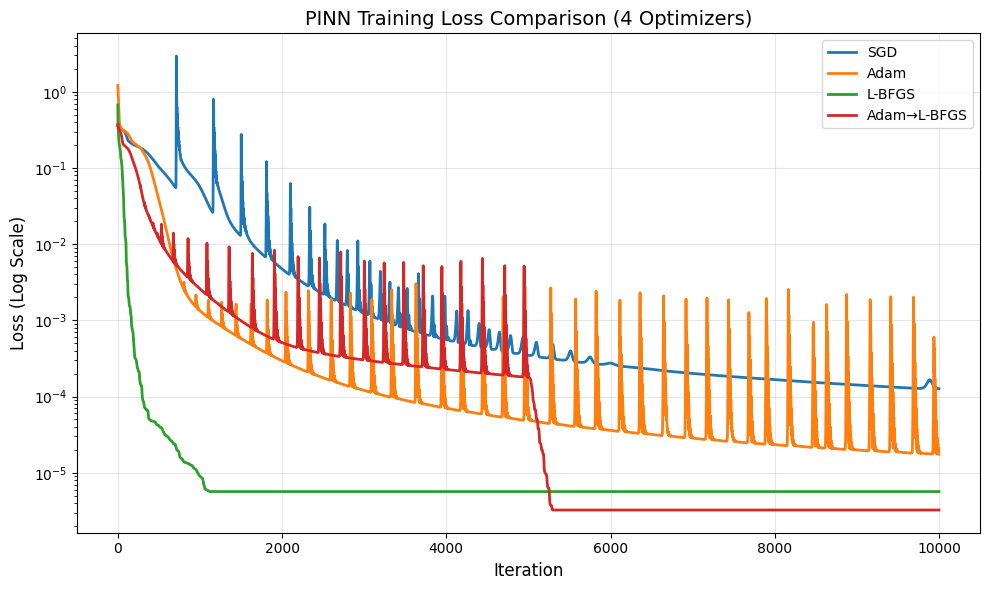

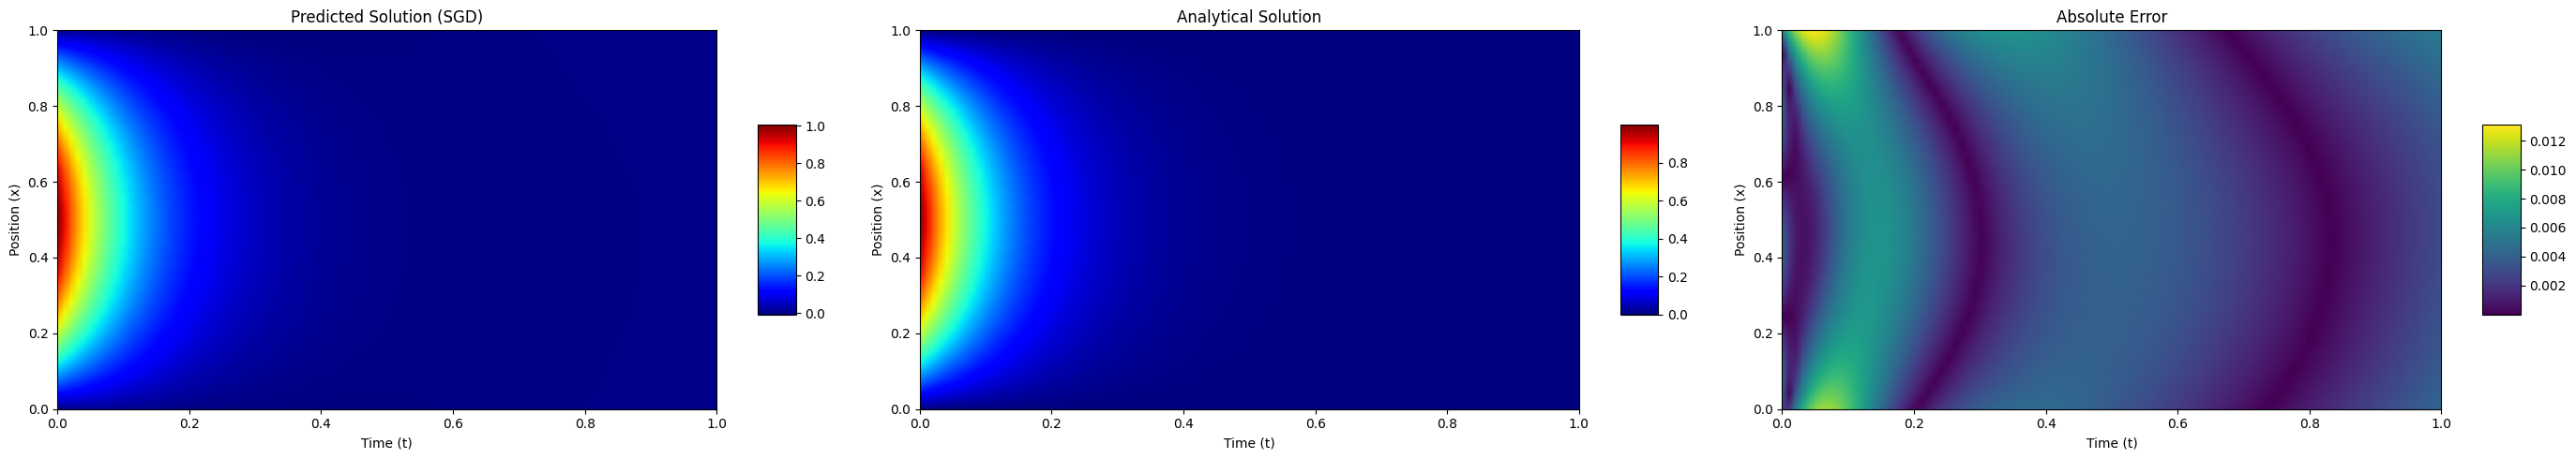

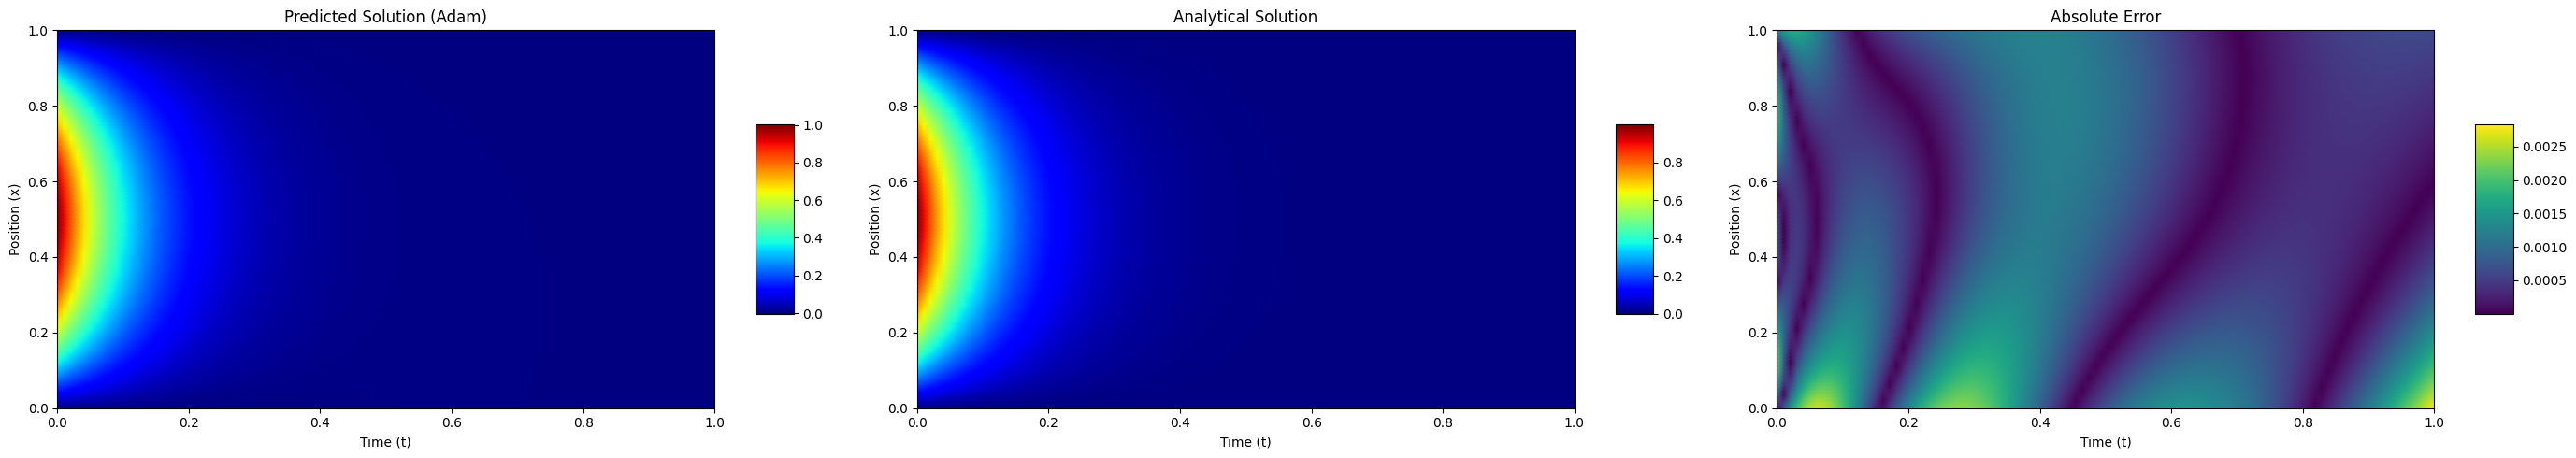

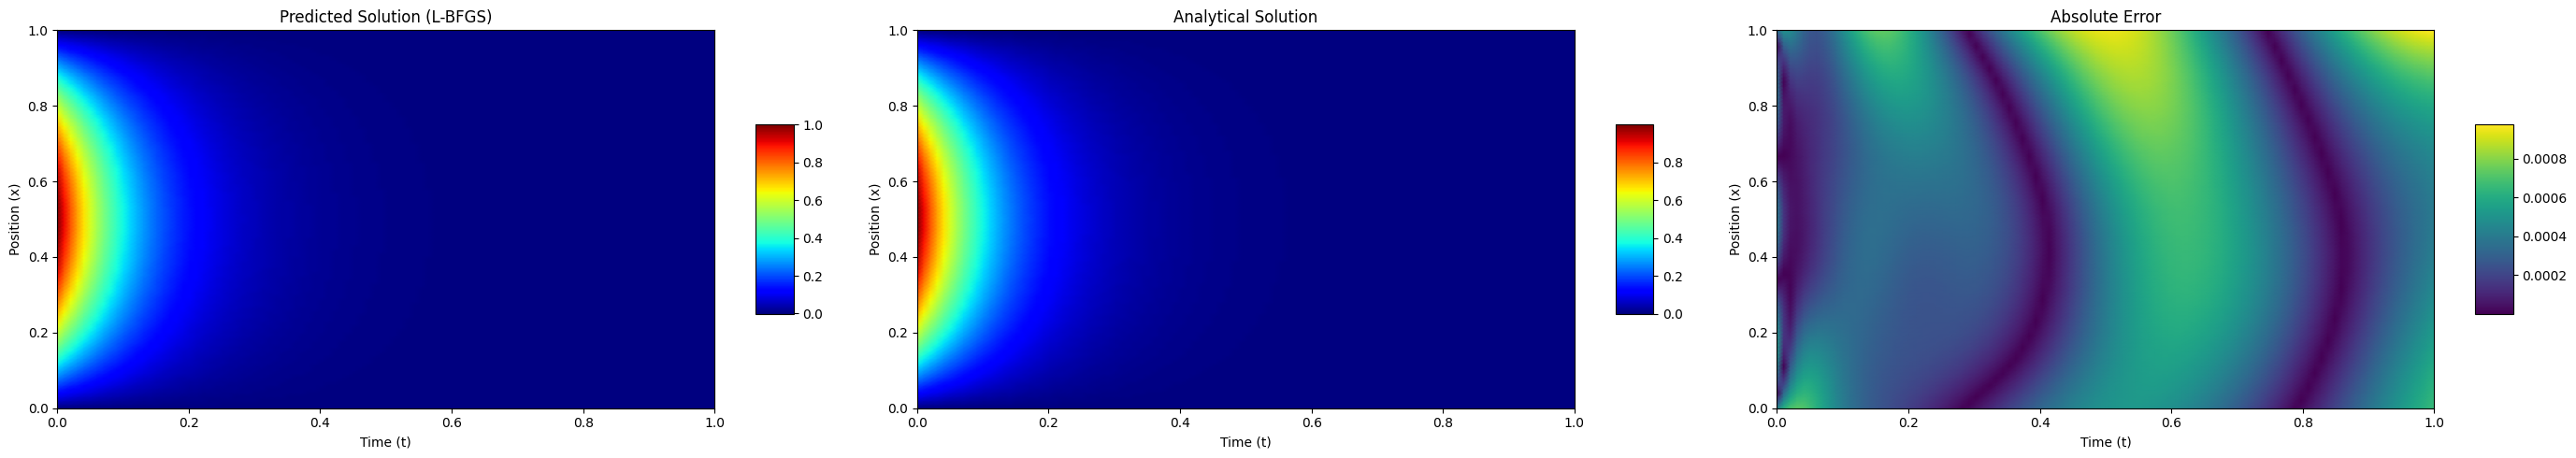

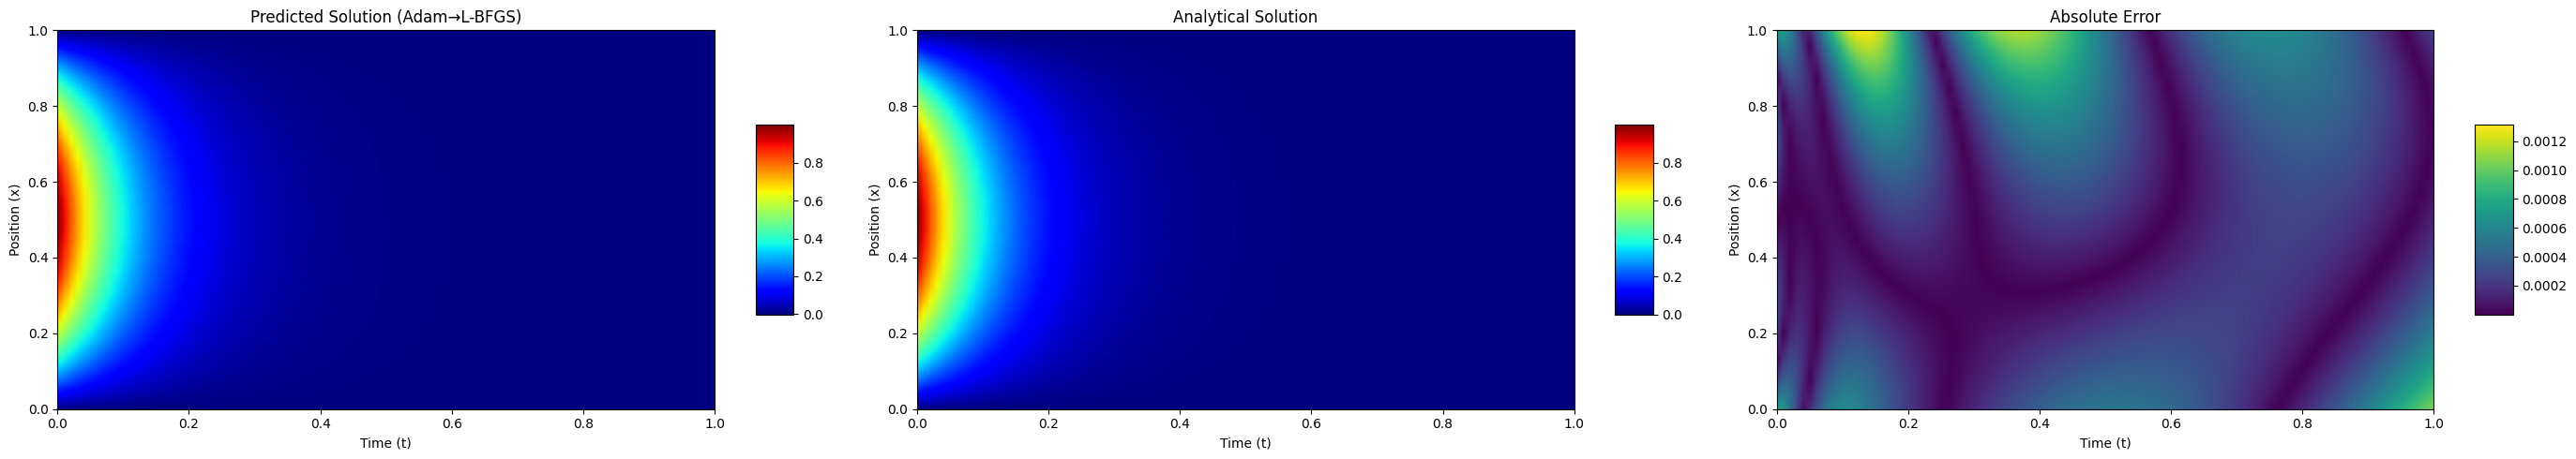


训练时间对比
SGD             | 训练时间: 70.69 秒 (1.18 分钟)
Adam            | 训练时间: 81.42 秒 (1.36 分钟)
L-BFGS          | 训练时间: 488.98 秒 (8.15 分钟)
Adam→L-BFGS     | 训练时间: 116.18 秒 (1.94 分钟)

最终L2误差对比
SGD             | L2 误差: 0.003678
Adam            | L2 误差: 0.000801
L-BFGS          | L2 误差: 0.000415
Adam→L-BFGS     | L2 误差: 0.000342


In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib import cm  
import matplotlib.pyplot as plt
import time

# 设置随机种子以保证结果可复现
torch.manual_seed(1224)
np.random.seed(1224)

# 1. 定义PINN模型
class PINN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, n_layers):
        super(PINN, self).__init__()
        # 输入层
        layers = [nn.Linear(input_dim, hidden_dim), nn.Tanh()]
        # 隐藏层，层数为 n_layers - 1
        for _ in range(n_layers - 1):
            layers.extend([nn.Linear(hidden_dim, hidden_dim), nn.Tanh()])
        # 输出层
        layers.append(nn.Linear(hidden_dim, output_dim))
        self.layers = nn.Sequential(*layers)
    
    # 前向传播
    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """前向传播：输入 x 和 t，输出预测值 u"""
        input_tensor = torch.cat([x, t], dim=1)  # 在列方向拼接 x 和 t
        for layer in self.layers:
            input_tensor = layer(input_tensor)
        return input_tensor

    # 计算偏导数的函数
    def compute_gradients(self, x: torch.Tensor, t: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """计算偏导数 u_t（对 t 的一阶偏导）和 u_xx（对 x 的二阶偏导）"""
        u = self.forward(x, t)  # 预测值
        # 计算 u_t：对 t 的一阶偏导
        u_t = torch.autograd.grad(
            outputs=u,
            inputs=t,
            grad_outputs=torch.ones_like(u),  # 与 u 形状相同的梯度输出张量
            create_graph=True,  # 保留计算图，用于二阶导数计算
            retain_graph=True,  # 保留计算图，避免后续计算报错
            only_inputs=True    # 仅计算输入的梯度
        )[0]
        # 计算 u_x：对 x 的一阶偏导
        u_x = torch.autograd.grad(
            outputs=u,
            inputs=x,
            grad_outputs=torch.ones_like(u),  # 与 u 形状相同的梯度输出张量
            create_graph=True,  # 保留计算图，用于二阶导数计算
            retain_graph=True,  # 保留计算图，避免后续计算报错
            only_inputs=True    # 仅计算输入的梯度
        )[0]
        # 计算 u_xx：对 x 的二阶偏导
        u_xx = torch.autograd.grad(
            outputs=u_x,
            inputs=x,
            grad_outputs=torch.ones_like(u_x),  # 与 u_x 形状相同的梯度输出张量
            create_graph=True,  # 保留计算图，用于后续计算
            retain_graph=True,  # 保留计算图，避免后续计算报错
            only_inputs=True    # 仅计算输入的梯度
        )[0]
        return u_t, u_xx

    # 定义PDE损失函数
    def pde_loss(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """PDE 损失：热方程 u_t - u_xx = 0"""
        u_t, u_xx = self.compute_gradients(x, t)  # 利用compute_gradients计算偏导数
        pde_residual = u_t - u_xx  # 计算PDE残差
        return torch.mean(pde_residual ** 2)
    
    # 定义初始条件损失函数
    def initial_loss(self, x: torch.Tensor, t0: torch.Tensor) -> torch.Tensor:
        """初始条件损失：u(x, 0) = sin(πx)"""
        u_pred = self.forward(x, t0)  # 模型预测初始时刻的值
        u_exact = torch.sin(np.pi * x)  # 精确初始条件
        initial_residual = u_pred - u_exact  # 计算初始条件残差
        return torch.mean(initial_residual ** 2)
    
    # 定义边界条件损失函数
    def boundary_loss(self, t: torch.Tensor) -> torch.Tensor:
        """边界条件损失：u(0, t) = 0 和 u(1, t) = 0"""
        x0 = torch.zeros_like(t)  # x=0 的边界点
        u0 = self.forward(x0, t)  # x=0 处的预测边界值
        x1 = torch.ones_like(t)   # x=1 的边界点
        u1 = self.forward(x1, t)  # x=1 处的预测边界值
        boundary_residual1 = u0  # 边界条件1的残差 u(0,t) - 0
        boundary_residual2 = u1  # 边界条件2的残差 u(1,t) - 0
        return torch.mean(boundary_residual1 ** 2) + torch.mean(boundary_residual2 ** 2)

# 2. 生成训练和测试数据
def generate_data(
    n_pde: int = 1000,
    n_initial: int = 200,
    n_boundary: int = 200,
    n_test: int = 100
) -> tuple:
    """
    生成训练数据（PDE内部点、初始条件点、边界条件点）和测试数据
    返回：(pde_data, initial_data, boundary_data, test_data)
    """
    # 训练数据（需要启用梯度）
    # PDE内部点：x ∈ [0,1], t ∈ [0,1]
    x_pde = torch.rand(n_pde, 1, requires_grad=True)  # 启用梯度
    t_pde = torch.rand(n_pde, 1, requires_grad=True)  # 启用梯度
    pde_data = (x_pde, t_pde)  # pde数据元组
    
    # 初始条件点：t=0, x ∈ [0,1]
    x_initial = torch.rand(n_initial, 1, requires_grad=True)  # 启用梯度
    t_initial = torch.zeros_like(x_initial, requires_grad=True)  # 启用梯度
    initial_data = (x_initial, t_initial)  # 初始条件数据元组
    
    # 边界条件点：x=0 和 x=1, t ∈ [0,1]
    t_boundary = torch.rand(n_boundary, 1, requires_grad=True)  # 启用梯度
    boundary_data = t_boundary  # 边界条件数据张量
    
    # 测试数据（不需要梯度）
    x_test = torch.linspace(0, 1, n_test).reshape(-1, 1)  # 不启用梯度（默认）
    t_test = torch.linspace(0, 1, n_test).reshape(-1, 1)  # 不启用梯度（默认）
    # 生成网格测试点，x_test_grid 和 t_test_grid 形状均为 (n_test, n_test)
    x_test_grid, t_test_grid = torch.meshgrid(x_test.squeeze(), t_test.squeeze(), indexing='ij')
    x_test_flat = x_test_grid.reshape(-1, 1)  # 网格测试点展开
    t_test_flat = t_test_grid.reshape(-1, 1)  # 网格测试点展开
    test_data = (x_test_flat, t_test_flat)  # 测试数据元组
    
    return pde_data, initial_data, boundary_data, test_data

# 3. 训练函数（SGD/Adam）
def train_with_optimizer(
    model: PINN,
    optimizer: optim.Optimizer,
    epochs: int,
    pde_data: tuple,
    initial_data: tuple,
    boundary_data: torch.Tensor,
    loss_history: list
) -> None:
    """使用SGD或Adam优化器训练模型"""
    x_pde, t_pde = pde_data  # pde数据元组
    x_initial, t_initial = initial_data  # 初始条件数据元组
    t_boundary = boundary_data  # 边界条件数据张量
    
    model.train()  # 切换到训练模式

    for epoch in range(epochs):
        # 计算各部分损失
        pde_loss = model.pde_loss(x_pde, t_pde)
        initial_loss = model.initial_loss(x_initial, t_initial)
        boundary_loss = model.boundary_loss(t_boundary)
        # 计算总损失
        total_loss = pde_loss + initial_loss + boundary_loss
        
        # 反向传播与参数更新
        optimizer.zero_grad()  # 清空梯度
        total_loss.backward()  # 反向传播计算梯度
        optimizer.step()       # 更新参数
        
        # 记录损失
        loss_history.append(total_loss.item())
        
        # 每1000个epoch打印一次进度
        if (epoch + 1) % 1000 == 0:
            print(
                f'轮数 {epoch+1:4d} | 总损失: {total_loss.item():.6f} | '
                f'PDE损失: {pde_loss.item():.6f} | 初始条件损失: {initial_loss.item():.6f} | '
                f'边界条件损失: {boundary_loss.item():.6f}'
            )

# 4. 训练函数（L-BFGS）
def train_with_lbfgs(
    model: PINN,
    pde_data: tuple,
    initial_data: tuple,
    boundary_data: torch.Tensor,
    loss_history: list,
    lr: float,
    max_iter: int
) -> None:
    """使用L-BFGS优化器训练模型（适合高精度收敛）"""
    x_pde, t_pde = pde_data
    x_initial, t_initial = initial_data
    t_boundary = boundary_data
    
    model.train()  # 切换到训练模式
    
    # 用于保存最新分量损失值
    pde_loss_val = initial_loss_val = boundary_loss_val = 0.0

    # 定义闭包函数（L-BFGS需要）
    def closure() -> torch.Tensor:
        nonlocal pde_loss_val, initial_loss_val, boundary_loss_val # 声明非局部变量
        optimizer.zero_grad()  # 清空梯度
        # 计算损失
        pde_loss = model.pde_loss(x_pde, t_pde)
        initial_loss = model.initial_loss(x_initial, t_initial)
        boundary_loss = model.boundary_loss(t_boundary)
        total_loss = pde_loss + initial_loss + boundary_loss
        # 反向传播
        total_loss.backward()
        
        # 保存当前分量值
        pde_loss_val = pde_loss.item()
        initial_loss_val = initial_loss.item()
        boundary_loss_val = boundary_loss.item()

        return total_loss
    
    # 初始化L-BFGS优化器
    optimizer = optim.LBFGS(
        model.parameters(),
        max_iter= 1,  # 最大迭代次数
        max_eval= 10,  # 最大函数评估次数
        line_search_fn='strong_wolfe',  # 线搜索策略
        lr= lr  # L-BFGS的学习率通常设为1.0
    )
    # 开始训练
    for iter_idx in range(max_iter):
        # 执行一次L-BFGS迭代
        total_loss = optimizer.step(closure)
        # 获取当前损失值
        current_loss = total_loss.item()
        # 记录当前损失
        loss_history.append(current_loss)
        # 打印迭代信息
        if (iter_idx + 1) % 500 == 0 or iter_idx == 0:
            print(
                f'迭代 {iter_idx+1}/{max_iter} | 总损失: {current_loss:.6f} | '
                f'PDE损失: {pde_loss_val:.6f} | 初始条件损失: {initial_loss_val:.6f} | '
                f'边界条件损失: {boundary_loss_val:.6f}'
            )

# 5. 两阶段训练函数（Adam→L-BFGS）
def train_adam_lbfgs(
    model: PINN,
    pde_data: tuple,
    initial_data: tuple,
    boundary_data: torch.Tensor,
    loss_history: list,
    adam_epochs: int,
    lr_lbfgs: float,
    lbfgs_max_iter: int
) -> None:
    """两阶段训练：先Adam全局探索，再L-BFGS局部精调"""
    print("\n=== 第一阶段：Adam全局探索 ===")
    # Adam优化器初始化
    optimizer_adam = optim.Adam(model.parameters(), lr=0.001)
    # 第一阶段：Adam训练
    train_with_optimizer(
        model=model,
        optimizer=optimizer_adam,
        epochs=adam_epochs,
        pde_data=pde_data,
        initial_data=initial_data,
        boundary_data=boundary_data,
        loss_history=loss_history
    )
    
    print("\n=== 第二阶段：L-BFGS局部精调 ===")
    # 第二阶段：L-BFGS训练（基于Adam的最终参数继续优化）
    train_with_lbfgs(
        model=model,
        pde_data=pde_data,
        initial_data=initial_data,
        boundary_data=boundary_data,
        loss_history=loss_history,
        lr=lr_lbfgs,
        max_iter=lbfgs_max_iter
    )

# 6. 评估函数
def evaluate_model(
    model: PINN,
    test_data: tuple,
    u_exact: torch.Tensor
) -> tuple[float, np.ndarray, np.ndarray]:
    """评估模型：计算L2误差、逐点误差和预测值"""
    x_test, t_test = test_data  # 测试数据元组
    model.eval()  # 切换到评估模式
    with torch.no_grad():  # 禁用梯度计算，加速推理
        u_pred = model(x_test, t_test)  # 前向传播获取预测值
    # 计算L2误差
    l2_error = torch.sqrt(torch.mean((u_pred - u_exact) ** 2)).item()
    # 转换为numpy数组用于可视化
    pointwise_error = torch.abs(u_pred - u_exact).numpy()  # 逐点误差
    u_pred_np = u_pred.numpy()  # 预测值转换为numpy数组
    return l2_error, pointwise_error, u_pred_np

# 7. 可视化函数
def plot_loss_curves(loss_histories: list, labels: list, title: str = 'Training Loss Comparison') -> None:
    """绘制不同优化器的损失曲线（对数刻度）"""
    plt.figure(figsize=(10, 6))
    for loss_history, label in zip(loss_histories, labels):
        plt.plot(loss_history, label=label, linewidth=2)
    plt.xlabel('Iteration', fontsize=12)
    plt.ylabel('Loss (Log Scale)', fontsize=12)
    plt.yscale('log')
    plt.title(title, fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_solution_comparison_2d(
    test_data: tuple,
    u_pred: np.ndarray,
    u_exact_np: np.ndarray,
    title: str
) -> None:
    """绘制二维预测解、精确解和误差图，色调与示例一致"""
    x_test, t_test = test_data
    n_test = int(np.sqrt(len(x_test)))  # 恢复网格尺寸
    # 重塑为网格形式
    x_grid = x_test.reshape(n_test, n_test)
    t_grid = t_test.reshape(n_test, n_test)
    u_pred_grid = u_pred.reshape(n_test, n_test)
    u_exact_grid = u_exact_np.reshape(n_test, n_test)
    error_grid = np.abs(u_pred_grid - u_exact_grid)
    
    # 创建3个子图
    fig = plt.figure(figsize=(28, 5))
    # 1. 预测解
    ax1 = fig.add_subplot(131)
    im1 = ax1.pcolormesh(t_grid, x_grid, u_pred_grid, cmap=cm.jet, shading='gouraud')
    ax1.set_xlabel('Time (t)', fontsize=10)
    ax1.set_ylabel('Position (x)', fontsize=10)
    ax1.set_title(f'Predicted Solution ({title})', fontsize=12)
    fig.colorbar(im1, ax=ax1, shrink=0.5, aspect=5)
    
    # 2. 精确解
    ax2 = fig.add_subplot(132)
    im2 = ax2.pcolormesh(t_grid, x_grid, u_exact_grid, cmap=cm.jet, shading='gouraud')
    ax2.set_xlabel('Time (t)', fontsize=10)
    ax2.set_ylabel('Position (x)', fontsize=10)
    ax2.set_title('Analytical Solution', fontsize=12)
    fig.colorbar(im2, ax=ax2, shrink=0.5, aspect=5)
    
    # 3. 绝对误差
    ax3 = fig.add_subplot(133)
    im3 = ax3.pcolormesh(t_grid, x_grid, error_grid, cmap=cm.viridis, shading='gouraud')
    ax3.set_xlabel('Time (t)', fontsize=10)
    ax3.set_ylabel('Position (x)', fontsize=10)
    ax3.set_title('Absolute Error', fontsize=12)
    fig.colorbar(im3, ax=ax3, shrink=0.5, aspect=5)
    
    plt.tight_layout()
    plt.show()

# 8. 主函数（执行流程）
def train_1D_heat_PINN():
    # 1. 超参数设置
    n_layers = 4              # 输入层和隐藏层数量
    input_dim = 2             # 输入维度（x 和 t）
    output_dim = 1            # 输出维度（u）
    hidden_dim = 20           # 每个隐藏层的神经元数量
    n_pde = 1000              # PDE内部点数量
    n_initial = 200           # 初始条件点数量
    n_boundary = 200          # 边界条件点数量
    n_test = 100              # 测试网格的维度（n_test x n_test 个点）
    epochs_sgd_adam = 10000   # SGD/Adam的训练轮数
    lr_lbfgs = 1.0            # L-BFGS的学习率
    lr_adam_lbfgs = 0.8       # 两阶段中L-BFGS的学习率
    max_iter_lbfgs = 10000    # 单独L-BFGS的最大迭代次数
    adam_lbfgs_adam_epochs = 5000  # 两阶段中Adam的轮数
    adam_lbfgs_lbfgs_iter = 5000    # 两阶段中L-BFGS的迭代次数
    
    # 2. 生成数据
    pde_data, initial_data, boundary_data, test_data = generate_data(
        n_pde=n_pde,
        n_initial=n_initial,
        n_boundary=n_boundary,
        n_test=n_test
    )
    x_test, t_test = test_data
    # 计算精确解：u_exact(x,t) = e^(-π²t) * sin(πx)
    u_exact = torch.exp(-np.pi**2 * t_test) * torch.sin(np.pi * x_test)
    u_exact_np = u_exact.numpy()  # 转换为numpy数组
    
    # 3. 初始化存储变量
    loss_histories = []  # 存储各优化器的损失历史
    l2_errors = []       # 存储各优化器的L2误差
    u_preds = []         # 存储各优化器的预测结果
    optim_labels = ['SGD', 'Adam', 'L-BFGS', 'Adam→L-BFGS']  # 优化器标签
    training_times = []   # 存储各优化器的训练时间

    # 4. 训练SGD
    print("\n" + "="*50)
    print("使用SGD训练")
    print("="*50)
    model_sgd = PINN(input_dim, output_dim, hidden_dim, n_layers)
    optimizer_sgd = optim.SGD(model_sgd.parameters(), lr=0.01, momentum=0.9)  # 添加动量加速收敛
    loss_history_sgd = []
    start_time_sgd = time.time()  # 记录开始时间
    train_with_optimizer(
        model=model_sgd,
        optimizer=optimizer_sgd,
        epochs=epochs_sgd_adam,
        pde_data=pde_data,
        initial_data=initial_data,
        boundary_data=boundary_data,
        loss_history=loss_history_sgd
    )
    end_time_sgd = time.time()  # 记录结束时间
    training_time_sgd = end_time_sgd - start_time_sgd  # 计算训练时间
    training_times.append(training_time_sgd)
    print(f"SGD训练时间: {training_time_sgd:.2f} 秒 ({training_time_sgd/60:.2f} 分钟)")

    # 评估SGD模型
    l2_error_sgd, _, u_pred_sgd = evaluate_model(model_sgd, test_data, u_exact)
    loss_histories.append(loss_history_sgd)
    l2_errors.append(l2_error_sgd)
    u_preds.append(u_pred_sgd)
    print(f"SGD L2 误差: {l2_error_sgd:.6f}")
    
    # 5. 训练Adam
    print("\n" + "="*50)
    print("使用Adam训练")
    print("="*50)
    model_adam = PINN(input_dim, output_dim, hidden_dim, n_layers)
    optimizer_adam = optim.Adam(model_adam.parameters(), lr=0.001)
    loss_history_adam = []
    start_time_adam = time.time()  # 记录开始时间
    train_with_optimizer(
        model=model_adam,
        optimizer=optimizer_adam,
        epochs=epochs_sgd_adam,
        pde_data=pde_data,
        initial_data=initial_data,
        boundary_data=boundary_data,
        loss_history=loss_history_adam
    )
    end_time_adam = time.time()  # 记录结束时间
    training_time_adam = end_time_adam - start_time_adam  # 计算训练时间
    training_times.append(training_time_adam)
    print(f"Adam训练时间: {training_time_adam:.2f} 秒 ({training_time_adam/60:.2f} 分钟)")

    # 评估Adam模型
    l2_error_adam, _, u_pred_adam = evaluate_model(model_adam, test_data, u_exact)
    loss_histories.append(loss_history_adam)
    l2_errors.append(l2_error_adam)
    u_preds.append(u_pred_adam)
    print(f"Adam L2 误差: {l2_error_adam:.6f}")
    
    # 6. 训练单独L-BFGS
    print("\n" + "="*50)
    print("使用L-BFGS训练")
    print("="*50)
    model_lbfgs = PINN(input_dim, output_dim, hidden_dim, n_layers)
    loss_history_lbfgs = []
    start_time_lbfgs = time.time()  # 记录开始时间
    train_with_lbfgs(
        model=model_lbfgs,
        pde_data=pde_data,
        initial_data=initial_data,
        boundary_data=boundary_data,
        loss_history=loss_history_lbfgs,
        lr=lr_lbfgs,
        max_iter=max_iter_lbfgs
    )
    end_time_lbfgs = time.time()  # 记录结束时间
    training_time_lbfgs = end_time_lbfgs - start_time_lbfgs  # 计算训练时间
    training_times.append(training_time_lbfgs)
    print(f"L-BFGS训练时间: {training_time_lbfgs:.2f} 秒 ({training_time_lbfgs/60:.2f} 分钟)")

    # 评估L-BFGS模型
    l2_error_lbfgs, _, u_pred_lbfgs = evaluate_model(model_lbfgs, test_data, u_exact)
    loss_histories.append(loss_history_lbfgs)
    l2_errors.append(l2_error_lbfgs)
    u_preds.append(u_pred_lbfgs)
    print(f"L-BFGS L2 误差: {l2_error_lbfgs:.6f}")
    
    # 7. 训练Adam→L-BFGS两阶段
    print("\n" + "="*50)
    print("使用Adam→L-BFGS两阶段训练")
    print("="*50)
    model_adam_lbfgs = PINN(input_dim, output_dim, hidden_dim, n_layers)
    loss_history_adam_lbfgs = []
    start_time_adam_lbfgs = time.time()  # 记录开始时间
    train_adam_lbfgs(
        model=model_adam_lbfgs,
        pde_data=pde_data,
        initial_data=initial_data,
        boundary_data=boundary_data,
        loss_history=loss_history_adam_lbfgs,
        lr_lbfgs=lr_adam_lbfgs,
        adam_epochs=adam_lbfgs_adam_epochs,
        lbfgs_max_iter=adam_lbfgs_lbfgs_iter
    )
    end_time_adam_lbfgs = time.time()  # 记录结束时间
    training_time_adam_lbfgs = end_time_adam_lbfgs - start_time_adam_lbfgs  # 计算训练时间
    training_times.append(training_time_adam_lbfgs)
    print(f"Adam→L-BFGS训练时间: {training_time_adam_lbfgs:.2f} 秒 ({training_time_adam_lbfgs/60:.2f} 分钟)")

    # 评估Adam→L-BFGS模型
    l2_error_adam_lbfgs, _, u_pred_adam_lbfgs = evaluate_model(model_adam_lbfgs, test_data, u_exact)
    loss_histories.append(loss_history_adam_lbfgs)
    l2_errors.append(l2_error_adam_lbfgs)
    u_preds.append(u_pred_adam_lbfgs)
    print(f"Adam→L-BFGS L2 误差: {l2_error_adam_lbfgs:.6f}")
    
    # 8. 结果可视化与对比
    # 绘制损失曲线（4种优化器对比）
    plot_loss_curves(loss_histories, optim_labels, title='PINN Training Loss Comparison (4 Optimizers)')
    
    # 绘制各优化器的解对比
    for i, (u_pred, label) in enumerate(zip(u_preds, optim_labels)):
        plot_solution_comparison_2d(test_data, u_pred, u_exact_np, title=label)
    
    # 打印最终训练时间对比
    print("\n" + "="*50)
    print("训练时间对比")
    print("="*50)
    for label, time_sec in zip(optim_labels, training_times):
        print(f"{label:15s} | 训练时间: {time_sec:.2f} 秒 ({time_sec/60:.2f} 分钟)")
    
    # 打印最终L2误差对比
    print("\n" + "="*50)
    print("最终L2误差对比")
    print("="*50)
    for label, error in zip(optim_labels, l2_errors):
        print(f"{label:15s} | L2 误差: {error:.6f}")

# 执行主函数
train_1D_heat_PINN()

以下给出五维热传导问题的代码示例，给出了Adam→L-BFGS和其他优化器的对比：


使用Adam训练
轮数 1000 | 总损失: 0.022076 | PDE损失: 0.000377 | 初始损失: 0.019123 | 边界损失: 0.002576
轮数 2000 | 总损失: 0.018900 | PDE损失: 0.000493 | 初始损失: 0.016363 | 边界损失: 0.002044
轮数 3000 | 总损失: 0.014957 | PDE损失: 0.000808 | 初始损失: 0.012702 | 边界损失: 0.001447
轮数 4000 | 总损失: 0.011485 | PDE损失: 0.001098 | 初始损失: 0.009321 | 边界损失: 0.001066
轮数 5000 | 总损失: 0.007960 | PDE损失: 0.001401 | 初始损失: 0.005761 | 边界损失: 0.000798
轮数 6000 | 总损失: 0.005186 | PDE损失: 0.001474 | 初始损失: 0.003196 | 边界损失: 0.000516
轮数 7000 | 总损失: 0.004018 | PDE损失: 0.001429 | 初始损失: 0.002199 | 边界损失: 0.000389
轮数 8000 | 总损失: 0.003609 | PDE损失: 0.001517 | 初始损失: 0.001565 | 边界损失: 0.000528
轮数 9000 | 总损失: 0.002501 | PDE损失: 0.000945 | 初始损失: 0.001258 | 边界损失: 0.000299
轮数 10000 | 总损失: 0.001900 | PDE损失: 0.000605 | 初始损失: 0.000917 | 边界损失: 0.000379
轮数 11000 | 总损失: 0.001651 | PDE损失: 0.000471 | 初始损失: 0.000917 | 边界损失: 0.000263
轮数 12000 | 总损失: 0.001340 | PDE损失: 0.000271 | 初始损失: 0.000770 | 边界损失: 0.000298
轮数 13000 | 总损失: 0.001338 | PDE损失: 0.000318 | 初始损失: 0.000706 | 边界损失: 0.00031

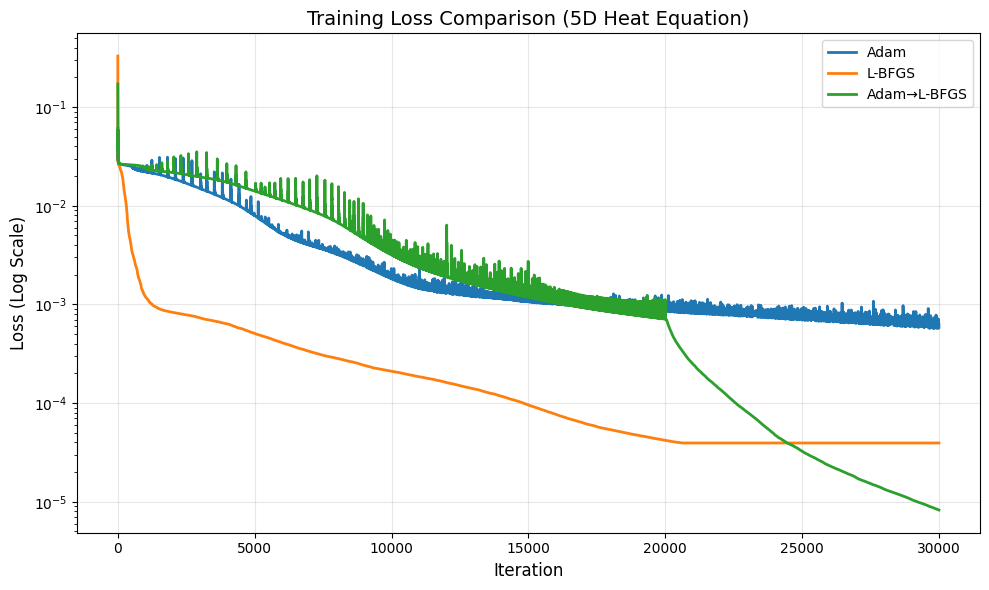


五维热方程解的二维可视化（所有模型）

--- 可视化 Adam 模型 (L²误差: 0.004560) ---


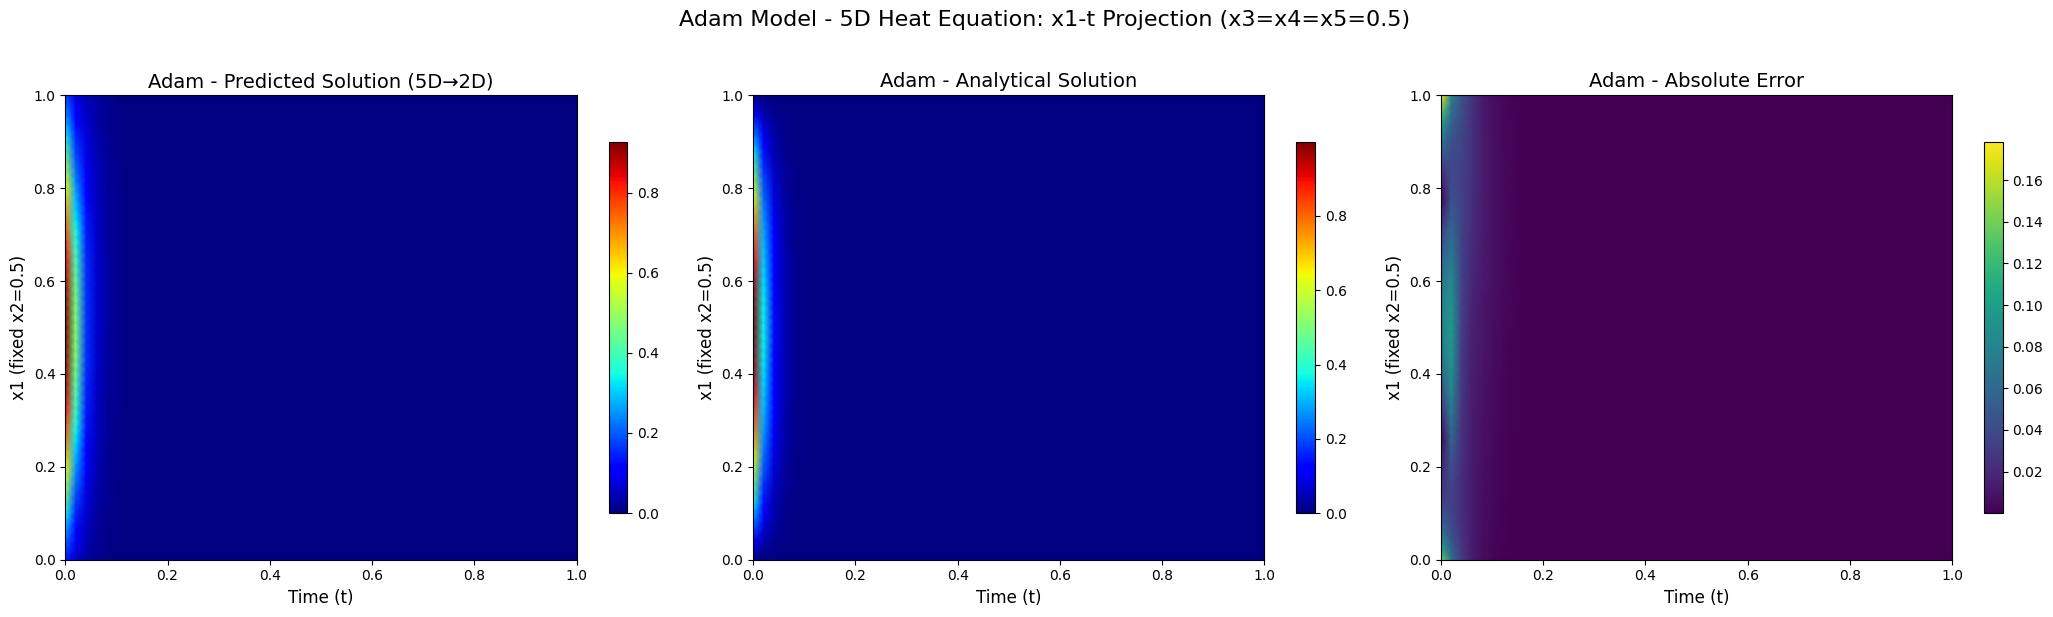

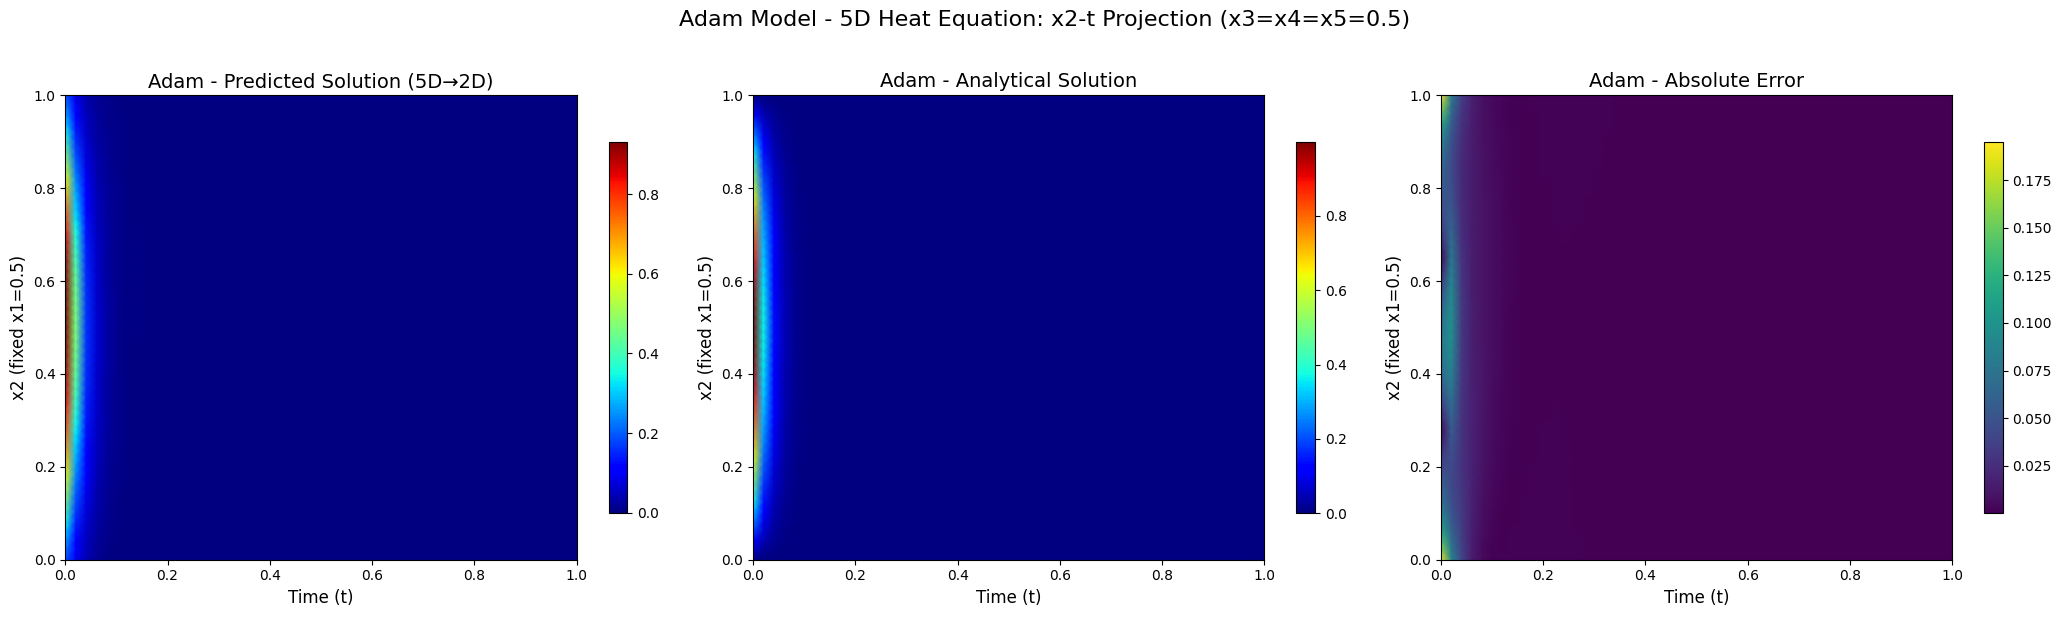


--- 可视化 L-BFGS 模型 (L²误差: 0.010170) ---


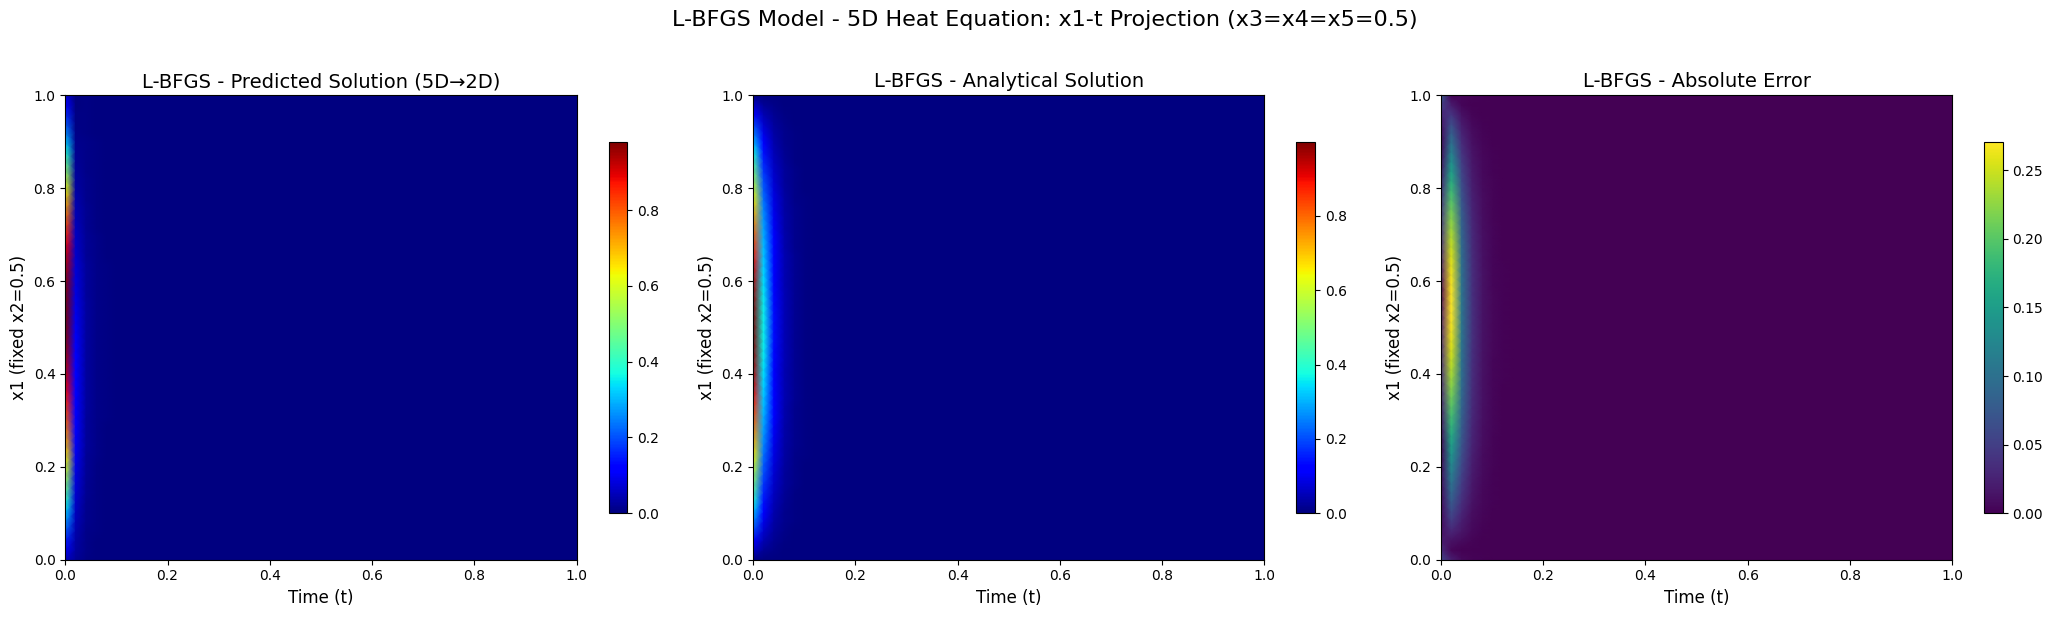

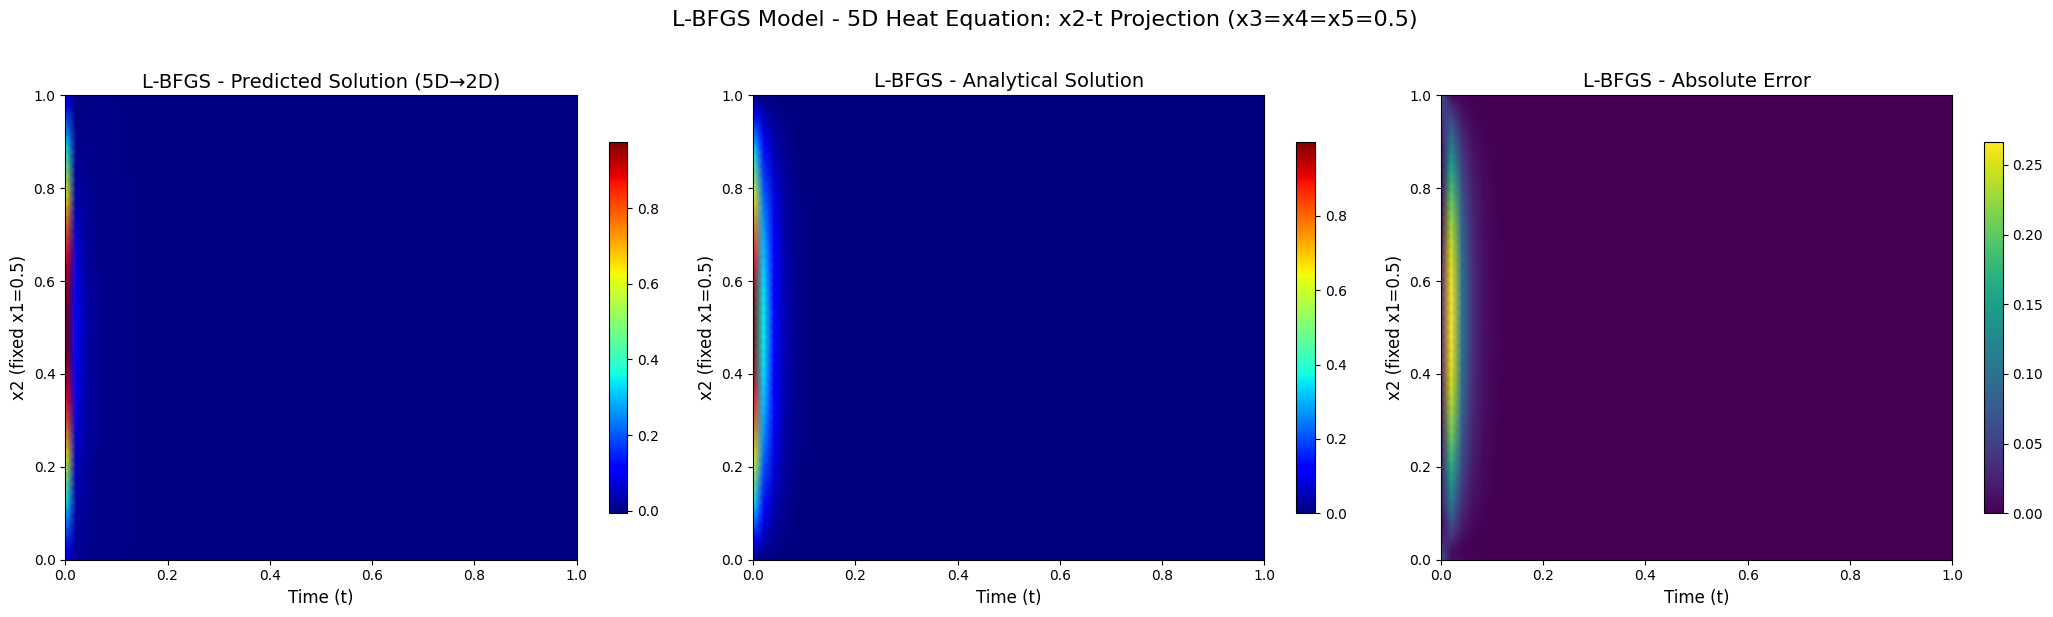


--- 可视化 Adam→L-BFGS 模型 (L²误差: 0.003292) ---


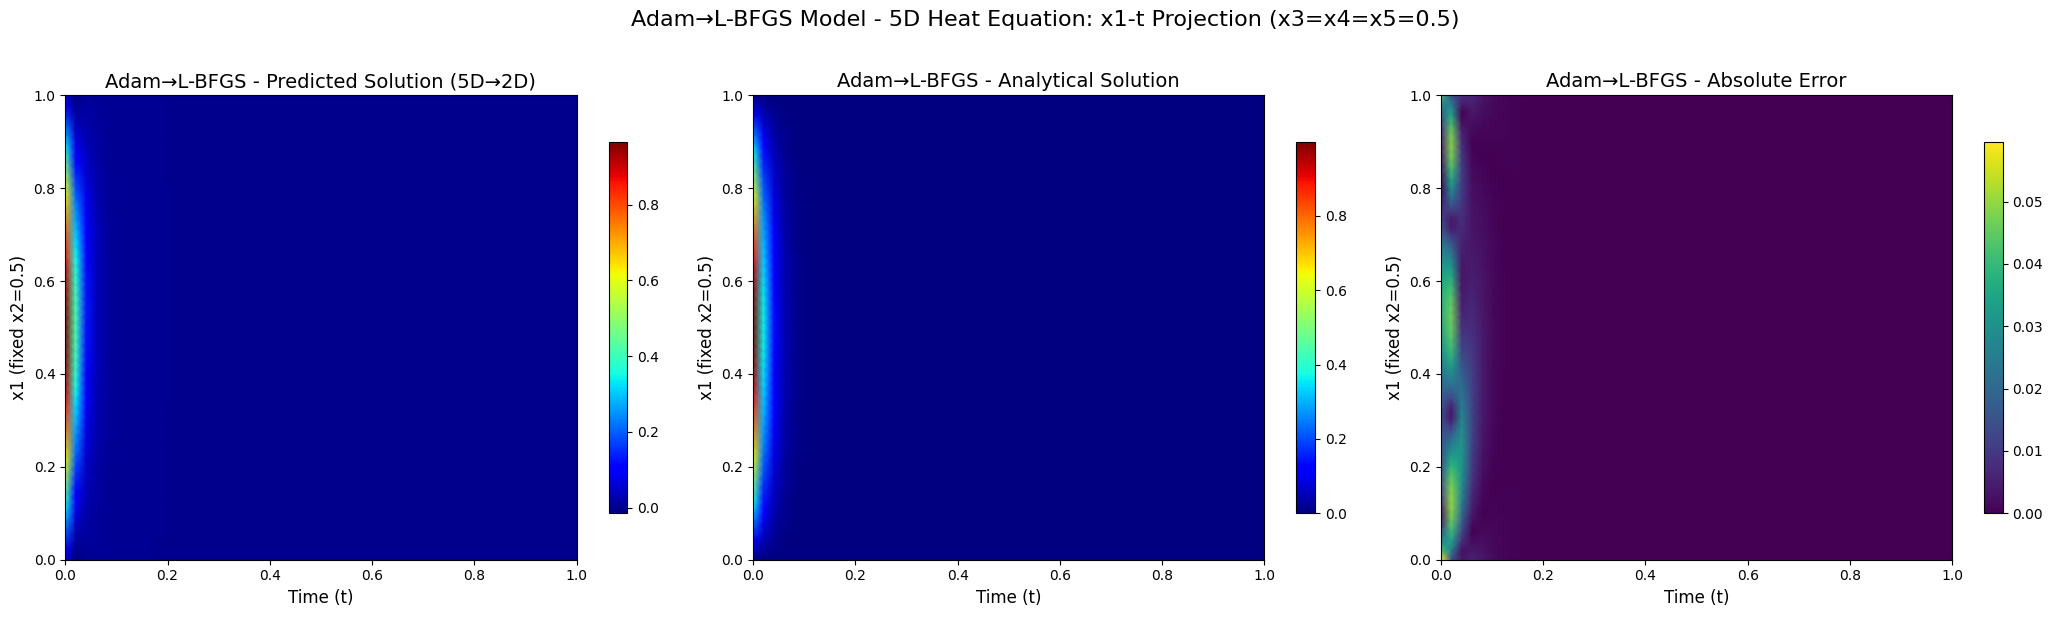

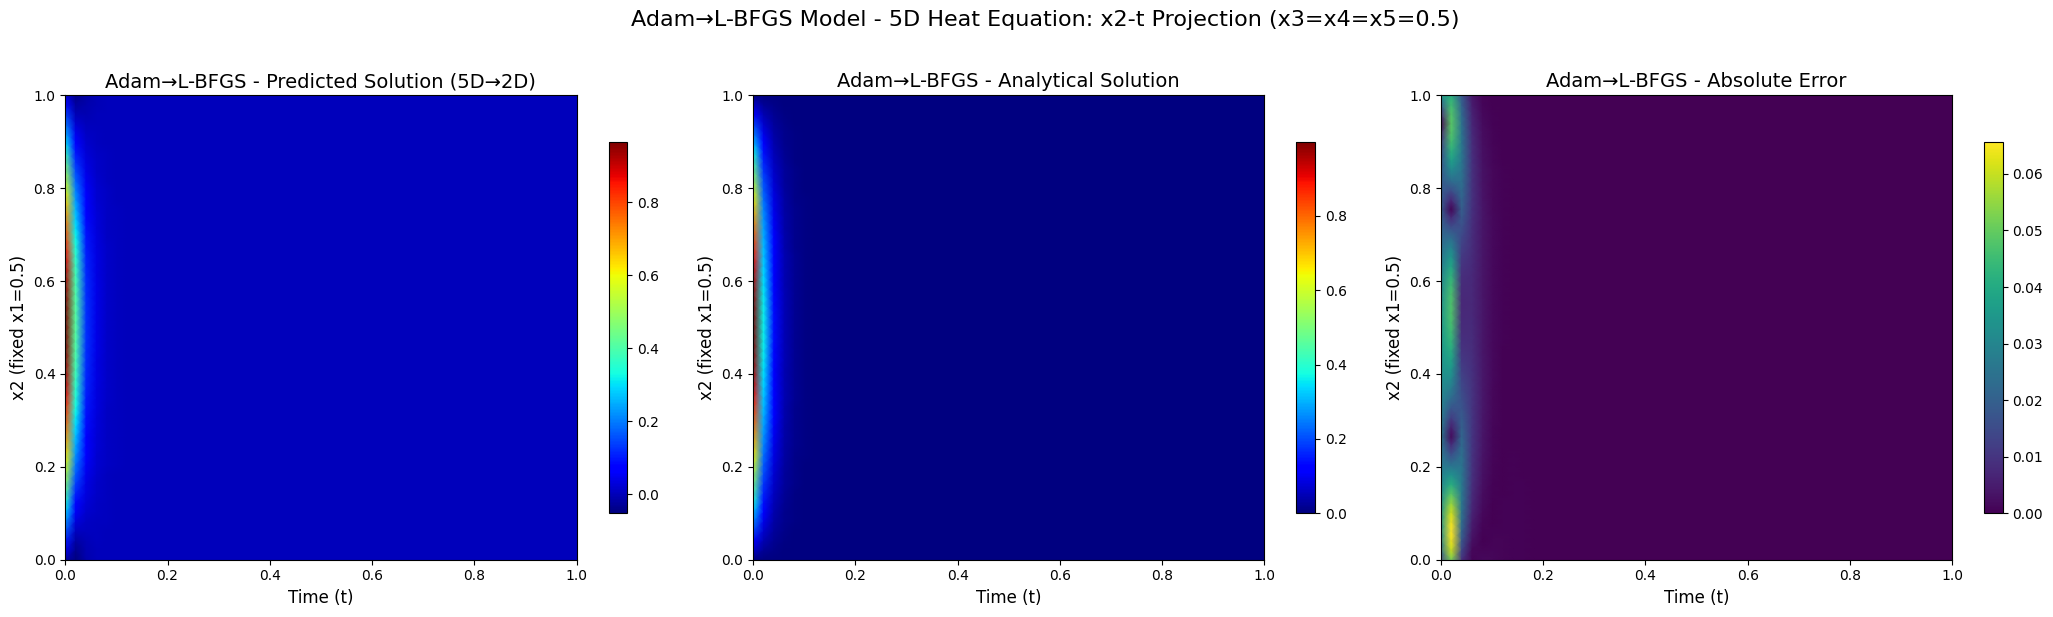


优化器训练时间对比
Adam       | 训练时间: 2326.65 秒 (38.78 分钟)
L-BFGS     | 训练时间: 11192.24 秒 (186.54 分钟)
Adam→L-BFGS | 训练时间: 3293.67 秒 (54.89 分钟)

最终L²误差对比
Adam    | L² 误差: 0.004560
L-BFGS  | L² 误差: 0.010170
Adam→L-BFGS | L² 误差: 0.003292


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib import cm
import matplotlib.pyplot as plt
import time

# 设置随机种子以保证结果可复现
torch.manual_seed(1224)
np.random.seed(1224)

# 1. 定义五维PINN模型
class PINN_5D(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, n_layers):
        super(PINN_5D, self).__init__()
        # 输入层：5个空间变量 + 1个时间变量 = 6维输入
        layers = [nn.Linear(input_dim, hidden_dim), nn.Tanh()]
        # 隐藏层
        for _ in range(n_layers - 1):
            layers.extend([nn.Linear(hidden_dim, hidden_dim), nn.Tanh()])
        # 输出层
        layers.append(nn.Linear(hidden_dim, output_dim))
        self.layers = nn.Sequential(*layers)
    
    # 前向传播
    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        input_tensor = torch.cat([x, t], dim=1)  # 拼接空间变量和时间变量
        for layer in self.layers:
            input_tensor = layer(input_tensor)
        return input_tensor

    # 计算偏导数：u_t（时间一阶偏导）和 Δu（五维拉普拉斯算子，即五个空间变量的二阶偏导之和）
    def compute_gradients(self, x: torch.Tensor, t: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        u = self.forward(x, t)  # 模型预测值
        
        # 计算 u_t：对时间 t 的一阶偏导
        u_t = torch.autograd.grad(
            outputs=u,
            inputs=t,
            grad_outputs=torch.ones_like(u),
            create_graph=True,
            retain_graph=True,
            only_inputs=True
        )[0]
        
        # 计算每个空间变量的二阶偏导，求和得到拉普拉斯算子Δu
        u_xx_sum = torch.zeros_like(u)
        for k in range(x.shape[1]):  # 遍历5个空间变量x1-x5
            # 一阶偏导
            u_xk = torch.autograd.grad(
                outputs=u,
                inputs=x,
                grad_outputs=torch.ones_like(u),
                create_graph=True,
                retain_graph=True,
                only_inputs=True
            )[0][:, k:k+1]  # 取第k个维度的偏导
            
            # 二阶偏导
            u_xkxk = torch.autograd.grad(
                outputs=u_xk,
                inputs=x,
                grad_outputs=torch.ones_like(u_xk),
                create_graph=True,
                retain_graph=True,
                only_inputs=True
            )[0][:, k:k+1]  # 取第k个维度的二阶偏导
            
            u_xx_sum += u_xkxk
        
        return u_t, u_xx_sum

    # PDE损失：五维热方程 u_t - Δu = 0
    def pde_loss(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        u_t, u_xx_sum = self.compute_gradients(x, t)
        pde_residual = u_t - u_xx_sum
        return torch.mean(pde_residual ** 2)
    
    # 初始条件损失：u(x1,...,x5, 0) = ∏_{k=1}^5 sin(πxk)
    def initial_loss(self, x: torch.Tensor, t0: torch.Tensor) -> torch.Tensor:
        u_pred = self.forward(x, t0)
        u_exact = torch.ones_like(u_pred)
        for k in range(x.shape[1]):  # 五个空间变量分别计算sin(πxk)后乘积
            u_exact *= torch.sin(np.pi * x[:, k:k+1])
        initial_residual = u_pred - u_exact
        return torch.mean(initial_residual ** 2)
    
    # 边界条件损失：对每个空间变量xk，u(0, x2,...,x5, t)=0 和 u(1, x2,...,x5, t)=0
    def boundary_loss(self, boundary_points: list) -> torch.Tensor:
        total_boundary_loss = 0.0
        for (x_bound, t_bound) in boundary_points:  # 遍历所有边界点
            u_pred = self.forward(x_bound, t_bound)
            total_boundary_loss += torch.mean(u_pred ** 2) # 边界条件残差
        return total_boundary_loss

# 2. 生成五维训练和测试数据
def generate_5d_data(
    n_pde: int = 2000,
    n_initial: int = 500,
    n_boundary_per_var: int = 100,  # 每个空间变量的边界点数量
    n_test: int = 5  # 测试时每个维度的采样数（总测试点为n_test^5，需适中）
) -> tuple:
    # PDE内部点：x1-x5 ∈ (0,1), t ∈ (0,1)
    x_pde = torch.rand(n_pde, 5, requires_grad=True)
    t_pde = torch.rand(n_pde, 1, requires_grad=True)
    pde_data = (x_pde, t_pde)
    
    # 初始条件点：t=0, x1-x5 ∈ (0,1)
    x_initial = torch.rand(n_initial, 5, requires_grad=True)
    t_initial = torch.zeros_like(x_initial[:, 0:1], requires_grad=True)  # t=0
    initial_data = (x_initial, t_initial)
    
    # 边界条件点：每个空间变量的x=0和x=1，t ∈ (0,1)
    boundary_points = []
    for k in range(5):
        # 边界 x_k = 0
        x0 = torch.rand(n_boundary_per_var, 5)  
        x0[:, k] = 0.0 # 设置第k个空间变量为0
        x0.requires_grad_()  # 原地开启梯度计算
        t0 = torch.rand(n_boundary_per_var, 1, requires_grad=True)
        boundary_points.append((x0, t0))

        # 边界 x_k = 1：同样先赋值再开启梯度
        x1 = torch.rand(n_boundary_per_var, 5)
        x1[:, k] = 1.0
        x1.requires_grad_()
        t1 = torch.rand(n_boundary_per_var, 1, requires_grad=True)
        boundary_points.append((x1, t1))
    boundary_data = boundary_points

    
    # 测试数据：蒙特卡洛随机采样（五维网格采样开销过大）
    n_test_total = n_test ** 5  # 总测试点数
    x_test = torch.rand(n_test_total, 5)
    t_test = torch.rand(n_test_total, 1)
    test_data = (x_test, t_test)
    
    return pde_data, initial_data, boundary_data, test_data

# 3. 训练函数（Adam）
def train_adam(
    model: PINN_5D,
    optimizer: optim.Optimizer,
    epochs: int,
    pde_data: tuple,
    initial_data: tuple,
    boundary_data: tuple,
    loss_history: list
) -> None:
    x_pde, t_pde = pde_data
    x_initial, t_initial = initial_data
    
    model.train()
    for epoch in range(epochs):
        # 计算各部分损失
        pde_loss = model.pde_loss(x_pde, t_pde)
        initial_loss = model.initial_loss(x_initial, t_initial)
        boundary_loss = model.boundary_loss(boundary_data)
        total_loss = pde_loss + initial_loss + boundary_loss
        
        # 反向传播与参数更新
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
        loss_history.append(total_loss.item())
        
        if (epoch + 1) % 1000 == 0:
            print(
                f'轮数 {epoch+1:4d} | 总损失: {total_loss.item():.6f} | '
                f'PDE损失: {pde_loss.item():.6f} | 初始损失: {initial_loss.item():.6f} | '
                f'边界损失: {boundary_loss.item():.6f}'
            )

# 4. 训练函数（L-BFGS）
def train_lbfgs(
    model: PINN_5D,
    pde_data: tuple,
    initial_data: tuple,
    boundary_data: tuple,
    loss_history: list,
    lr: float,
    max_iter: int
) -> None:
    x_pde, t_pde = pde_data
    x_initial, t_initial = initial_data
    
    model.train()

    # 用于保存最新分量损失值
    pde_loss_val = initial_loss_val = boundary_loss_val = 0.0
    
    def closure() -> torch.Tensor:
        nonlocal pde_loss_val, initial_loss_val, boundary_loss_val # 声明非局部变量
        optimizer.zero_grad()
        # 计算损失
        pde_loss = model.pde_loss(x_pde, t_pde)
        initial_loss = model.initial_loss(x_initial, t_initial)
        boundary_loss = model.boundary_loss(boundary_data)
        total_loss = pde_loss + initial_loss + boundary_loss
        # 反向传播
        total_loss.backward()

        # 保存当前分量值
        pde_loss_val = pde_loss.item()
        initial_loss_val = initial_loss.item()
        boundary_loss_val = boundary_loss.item()

        return total_loss
    
    # 初始化L-BFGS优化器
    optimizer = optim.LBFGS(
        model.parameters(),
        max_iter= 1,  # 最大迭代次数
        max_eval= 10,  # 最大函数评估次数
        line_search_fn='strong_wolfe',  # 线搜索策略
        lr=lr  # L-BFGS的学习率通常设为1.0
    )
    
    # 开始训练
    for iter_idx in range(max_iter):
        # 执行一次L-BFGS迭代
        total_loss = optimizer.step(closure)
        # 获取当前损失值
        current_loss = total_loss.item()
        # 记录当前损失
        loss_history.append(current_loss)
        # 打印迭代信息
        if (iter_idx + 1) % 500 == 0 or iter_idx == 0:
            print(
                f'迭代 {iter_idx+1}/{max_iter} | 总损失: {current_loss:.6f} | '
                f'PDE损失: {pde_loss_val:.6f} | 初始条件损失: {initial_loss_val:.6f} | '
                f'边界条件损失: {boundary_loss_val:.6f}'
            )

# 5. 两阶段训练函数（Adam→L-BFGS）
def train_adam_lbfgs(
    model: PINN_5D,
    pde_data: tuple,
    initial_data: tuple,
    boundary_data: torch.Tensor,
    loss_history: list,
    adam_epochs: int,
    lr_lbfgs: float,
    lbfgs_max_iter: int
) -> None:
    """两阶段训练：先Adam全局探索，再L-BFGS局部精调"""
    print("\n=== 第一阶段：Adam全局探索 ===")
    # Adam优化器初始化
    optimizer_adam = optim.Adam(model.parameters(), lr=0.001)
    # 第一阶段：Adam训练
    train_adam(
        model=model,
        optimizer=optimizer_adam,
        epochs=adam_epochs,
        pde_data=pde_data,
        initial_data=initial_data,
        boundary_data=boundary_data,
        loss_history=loss_history
    )
    
    print("\n=== 第二阶段：L-BFGS局部精调 ===")
    # 第二阶段：L-BFGS训练（基于Adam的最终参数继续优化）
    train_lbfgs(
        model=model,
        pde_data=pde_data,
        initial_data=initial_data,
        boundary_data=boundary_data,
        loss_history=loss_history,
        lr=lr_lbfgs,
        max_iter=lbfgs_max_iter
    )


# 6. 评估函数（L²误差）
def evaluate_5d(
    model: PINN_5D,
    test_data: tuple,
    lambda_val: float
) -> float:
    x_test, t_test = test_data
    model.eval()
    with torch.no_grad():
        u_pred = model(x_test, t_test)
        # 计算精确解：u_exact = e^(-λ t) * ∏_{k=1}^5 sin(π xk)，其中λ=5π²
        u_exact = torch.exp(-lambda_val * t_test)
        for k in range(5):
            u_exact *= torch.sin(np.pi * x_test[:, k:k+1])
        # 计算L²误差
        l2_error = torch.sqrt(torch.mean((u_pred - u_exact) ** 2)).item()
    return l2_error

# 7. 绘制损失曲线
def plot_loss_curve(loss_histories: list, labels: list) -> None:
    plt.figure(figsize=(10, 6))
    for loss_history, label in zip(loss_histories, labels):
        plt.plot(loss_history, label=label, linewidth=2)
    plt.xlabel('Iteration', fontsize=12)
    plt.ylabel('Loss (Log Scale)', fontsize=12)
    plt.yscale('log')
    plt.title('Training Loss Comparison (5D Heat Equation)', fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# 8. 新增：五维转二维可视化函数（固定x3=x4=x5=0.5，展示x1-t/x2-t的解分布）
def plot_5d_to_2d(
    model: PINN_5D,
    lambda_val: float,
    n_grid: int = 50,
    fixed_vals: float = 0.5,
    plot_dim: tuple = (0, 1),
    model_name: str = "Unknown"  # 新增：模型名称（用于标题区分）
) -> None:
    """
    将五维热方程解投影到二维可视化：
    - 固定x3-x5为fixed_vals，展示x_plot1-t 或 x_plot2-t 的解分布
    - plot_dim: 要可视化的两个空间维度索引（如(0,1)表示x1和x2）
    - model_name: 模型名称（Adam/L-BFGS/Adam→L-BFGS），用于标题区分
    """
    # 生成网格：x1/x2 ∈ [0,1], t ∈ [0,1]
    x1 = np.linspace(0, 1, n_grid)
    t = np.linspace(0, 1, n_grid)
    x1_grid, t_grid = np.meshgrid(x1, t)
    
    # 构造五维输入：x_plot1, x_plot2, fixed, fixed, fixed
    x_plot1_idx, x_plot2_idx = plot_dim
    x_5d = np.zeros((n_grid*n_grid, 5))
    t_1d = t_grid.flatten()[:, None]
    
    # 填充要可视化的维度
    x_5d[:, x_plot1_idx] = x1_grid.flatten()
    x_5d[:, x_plot2_idx] = fixed_vals  # 固定第二个维度为0.5（或改为遍历）
    # 固定其余维度
    for k in range(5):
        if k not in [x_plot1_idx, x_plot2_idx]:
            x_5d[:, k] = fixed_vals
    
    # 转换为tensor
    x_5d_tensor = torch.tensor(x_5d, dtype=torch.float32)
    t_tensor = torch.tensor(t_1d, dtype=torch.float32)
    
    # 预测解
    model.eval()
    with torch.no_grad():
        u_pred = model(x_5d_tensor, t_tensor).numpy().reshape(n_grid, n_grid)
    
    # 计算精确解：u_exact = e^(-λ t) * ∏_{k=1}^5 sin(π xk)
    u_exact = np.exp(-lambda_val * t_grid)
    u_exact *= np.sin(np.pi * x1_grid)  # x_plot1
    u_exact *= np.sin(np.pi * fixed_vals)  # x_plot2
    for k in range(5):
        if k not in [x_plot1_idx, x_plot2_idx]:
            u_exact *= np.sin(np.pi * fixed_vals)  # x3-x5
    
    # 计算绝对误差
    error = np.abs(u_pred - u_exact)
    
    # 绘制对比图
    fig, axes = plt.subplots(1, 3, figsize=(21, 6))
    dim_names = ['x1', 'x2', 'x3', 'x4', 'x5']
    plot_dim1, plot_dim2 = dim_names[x_plot1_idx], dim_names[x_plot2_idx]
    
    # 预测解（标题增加模型名称）
    im1 = axes[0].pcolormesh(t_grid, x1_grid, u_pred, cmap=cm.jet, shading='gouraud')
    axes[0].set_xlabel('Time (t)', fontsize=12)
    axes[0].set_ylabel(f'{plot_dim1} (fixed {plot_dim2}={fixed_vals})', fontsize=12)
    axes[0].set_title(f'{model_name} - Predicted Solution (5D→2D)', fontsize=14)
    plt.colorbar(im1, ax=axes[0], shrink=0.8)
    
    # 精确解（标题增加模型名称）
    im2 = axes[1].pcolormesh(t_grid, x1_grid, u_exact, cmap=cm.jet, shading='gouraud')
    axes[1].set_xlabel('Time (t)', fontsize=12)
    axes[1].set_ylabel(f'{plot_dim1} (fixed {plot_dim2}={fixed_vals})', fontsize=12)
    axes[1].set_title(f'{model_name} - Analytical Solution', fontsize=14)
    plt.colorbar(im2, ax=axes[1], shrink=0.8)
    
    # 绝对误差（标题增加模型名称）
    im3 = axes[2].pcolormesh(t_grid, x1_grid, error, cmap=cm.viridis, shading='gouraud')
    axes[2].set_xlabel('Time (t)', fontsize=12)
    axes[2].set_ylabel(f'{plot_dim1} (fixed {plot_dim2}={fixed_vals})', fontsize=12)
    axes[2].set_title(f'{model_name} - Absolute Error', fontsize=14)
    plt.colorbar(im3, ax=axes[2], shrink=0.8)
    
    # 总标题增加模型名称和投影维度
    plt.suptitle(
        f'{model_name} Model - 5D Heat Equation: {plot_dim1}-t Projection (x3=x4=x5={fixed_vals})',
        fontsize=16,
        y=1.02  # 微调位置避免重叠
    )
    plt.tight_layout()
    plt.show()

# 9. 主函数
def train_5D_heat_PINN():
    # 超参数
    n_layers = 4               # 输入层和隐藏层数量
    input_dim = 6              # 5个空间变量 + 1个时间变量
    output_dim = 1             # 输出维度（u）
    hidden_dim = 30            # 五维问题需增加隐藏层神经元数以提升表达能力
    n_pde = 2000               # 五维PDE点数量需增加
    n_initial = 500            # 初始条件点数量
    n_boundary_per_var = 200   # 每个空间变量的边界点数量
    epochs_adam = 30000        # Adam训练轮数
    max_iter_lbfgs = 30000     # L-BFGS迭代次数
    adam_lbfgs_adam_epochs = 20000  # 两阶段中Adam的轮数
    adam_lbfgs_lbfgs_iter = 10000   # 两阶段中L-BFGS的迭代次数
    lr_lbfgs = 1.0           # L-BFGS学习率
    lr_adam_lbfgs = 0.8     # 两阶段中L-BFGS的学习率
    lambda_val = 5 * np.pi**2  # 五维时λ=5π²
    
    # 生成数据
    pde_data, initial_data, boundary_data, test_data = generate_5d_data(
        n_pde=n_pde,
        n_initial=n_initial,
        n_boundary_per_var=n_boundary_per_var,
        n_test=5
    )
    
    training_times = [] # 存储训练时间

    # 训练Adam
    print("\n" + "="*50)
    print("使用Adam训练")
    print("="*50)
    model_adam = PINN_5D(input_dim, output_dim, hidden_dim, n_layers)
    optimizer_adam = optim.Adam(model_adam.parameters(), lr=0.001)
    loss_history_adam = []
    start_time_adam = time.time() # 记录开始时间
    train_adam(
        model=model_adam,
        optimizer=optimizer_adam,
        epochs=epochs_adam,
        pde_data=pde_data,
        initial_data=initial_data,
        boundary_data=boundary_data,
        loss_history=loss_history_adam
    )
    end_time_adam = time.time() # 记录结束时间
    training_time_adam = end_time_adam - start_time_adam # 计算训练时间
    training_times.append(training_time_adam)
    print(f"Adam训练时间: {training_time_adam:.2f} 秒({training_time_adam/60:.2f} 分钟)")

    l2_error_adam = evaluate_5d(model_adam, test_data, lambda_val)
    print(f"Adam L² 误差: {l2_error_adam:.6f}")
    
    # 训练L-BFGS
    print("\n" + "="*50)
    print("使用L-BFGS训练")
    print("="*50)
    model_lbfgs = PINN_5D(input_dim, output_dim, hidden_dim, n_layers)
    loss_history_lbfgs = []
    start_time_lbfgs = time.time() # 记录开始时间
    train_lbfgs(
        model=model_lbfgs,
        pde_data=pde_data,
        initial_data=initial_data,
        boundary_data=boundary_data,
        loss_history=loss_history_lbfgs,
        lr=lr_lbfgs,
        max_iter=max_iter_lbfgs
    )
    end_time_lbfgs = time.time() # 记录结束时间
    training_time_lbfgs = end_time_lbfgs - start_time_lbfgs # 计算训练时间
    training_times.append(training_time_lbfgs)
    print(f"L-BFGS训练时间: {training_time_lbfgs:.2f} 秒({training_time_lbfgs/60:.2f} 分钟)")

    l2_error_lbfgs = evaluate_5d(model_lbfgs, test_data, lambda_val)
    print(f"L-BFGS L² 误差: {l2_error_lbfgs:.6f}")
    
    # 两阶段训练（Adam→L-BFGS）
    print("\n" + "="*50)
    print("使用Adam→L-BFGS两阶段训练")
    print("="*50)
    model_adam_lbfgs = PINN_5D(input_dim, output_dim, hidden_dim, n_layers)
    loss_history_adam_lbfgs = []
    start_time_adam_lbfgs = time.time() # 记录开始时间
    train_adam_lbfgs(
        model=model_adam_lbfgs,
        pde_data=pde_data,
        initial_data=initial_data,
        boundary_data=boundary_data,
        loss_history=loss_history_adam_lbfgs,
        adam_epochs=adam_lbfgs_adam_epochs,
        lr_lbfgs=lr_adam_lbfgs,
        lbfgs_max_iter=adam_lbfgs_lbfgs_iter
    )
    end_time_adam_lbfgs = time.time() # 记录结束时间
    training_time_adam_lbfgs = end_time_adam_lbfgs - start_time_adam_lbfgs # 计算训练时间
    training_times.append(training_time_adam_lbfgs)
    print(f"Adam→L-BFGS两阶段训练时间: {training_time_adam_lbfgs:.2f} 秒({training_time_adam_lbfgs/60:.2f} 分钟)")

    l2_error_adam_lbfgs = evaluate_5d(model_adam_lbfgs, test_data, lambda_val)
    print(f"Adam→L-BFGS两阶段训练 L² 误差: {l2_error_adam_lbfgs:.6f}")

    # 绘制损失曲线
    plot_loss_curve([loss_history_adam, loss_history_lbfgs, loss_history_adam_lbfgs], ['Adam', 'L-BFGS', 'Adam→L-BFGS'])
    
    print("\n" + "="*50)
    print("五维热方程解的二维可视化（所有模型）")
    print("="*50)

    # 整理所有模型、名称和误差
    all_models = [model_adam, model_lbfgs, model_adam_lbfgs]
    all_model_names = ['Adam', 'L-BFGS', 'Adam→L-BFGS']
    all_errors = [l2_error_adam, l2_error_lbfgs, l2_error_adam_lbfgs]

    # 遍历所有模型，逐个可视化
    for idx, (model, name, error) in enumerate(zip(all_models, all_model_names, all_errors)):
        print(f"\n--- 可视化 {name} 模型 (L²误差: {error:.6f}) ---")
        
        # 可视化1：x1-t 投影（固定x2-x5=0.5）
        plot_5d_to_2d(
            model=model,
            lambda_val=lambda_val,
            plot_dim=(0, 1),
            model_name=name
        )
        
        # 可视化2：x2-t 投影（固定x1,x3-x5=0.5）
        plot_5d_to_2d(
            model=model,
            lambda_val=lambda_val,
            plot_dim=(1, 0),
            model_name=name
        )

    # 打印训练时间对比
    print("\n" + "="*50)
    print("优化器训练时间对比")
    print("="*50)
    optimizers = ['Adam', 'L-BFGS', 'Adam→L-BFGS']
    for opt, time_sec in zip(optimizers, training_times):
        print(f"{opt:<10} | 训练时间: {time_sec:.2f} 秒 ({time_sec/60:.2f} 分钟)")

    # 打印最终误差对比
    print("\n" + "="*50)
    print("最终L²误差对比")
    print("="*50)
    print(f"Adam    | L² 误差: {l2_error_adam:.6f}")
    print(f"L-BFGS  | L² 误差: {l2_error_lbfgs:.6f}")
    print(f"Adam→L-BFGS | L² 误差: {l2_error_adam_lbfgs:.6f}")

# 执行主函数
train_5D_heat_PINN()

根据论文《[Challenges in Training PINNs: A Loss Landscape Perspective](https://doi.org/10.48550/arXiv.2402.01868)》的研究表明，物理知情神经网络（PINNs）训练过程中，其损失函数对应的海森矩阵存在显著的病态性，且谱衰减速度较快。这一特性导致无预条件化的共轭梯度法收敛效率低下，难以快速逼近最优解。为此，我们采用奈斯特龙预条件共轭梯度法（Nyström-PCG），该方法专为求解谱快速衰减的线性系统设计，能通过预条件化技术有效缓解海森矩阵的病态性问题，提升收敛性能。

尽管新型二阶优化器NNCG（NysNewton-CG）在改善PINNs的求解精度方面表现突出，且其线搜索条件相较于L-BFGS更为简洁，但直接用NNCG完全替代L-BFGS并非最优方案。核心原因在于NNCG的运行效率低于L-BFGS：L-BFGS的更新计算时间复杂度仅为$O(mp)$（其中$m$为内存参数），而NNCG仅单次更新所需的海森向量积计算，时间复杂度就达到$O((n_{res}+n_{bc})p)$，计算开销显著更高。因此，在实际应用中，建议采用“分步优化”策略：先通过Adam+L-BFGS组合优化方法推进收敛进程，完成大部分收敛迭代，再切换至NNCG进行后续精细化优化，从而在收敛速度与求解精度之间实现最优平衡。

### 算法：奈斯特龙牛顿共轭梯度法（Nyström Newton-CG）
奈斯特龙牛顿共轭梯度法是融合低秩近似与牛顿-CG框架的高效优化算法，核心思想是通过Nyström方法对Hessian矩阵进行低秩逼近，再用共轭梯度法求解近似牛顿方程，在保持牛顿法二阶收敛特性的同时，将计算复杂度从$O(n^3)$降至低秩相关的线性/亚线性复杂度，适用于大规模无约束优化问题（如高维模型训练、大数据拟合等）。

#### 算法 Nyström Newton-CG：低秩近似牛顿型优化算法
1. **输入**：初始参数 $x^0$、收敛阈值 $\varepsilon$（常用 $\varepsilon=10^{-6}$）、最大迭代次数 $K$、损失函数 $f(x)$、Nyström采样参数（采样点数 $m$，$m \ll n$，$n$ 为参数维度；采样集 $S \subseteq \{1,2,...,n\}$）、线搜索参数（$\alpha \in (0,0.5)$，$\beta \in (0,1)$，常用 $\alpha=0.0001$，$\beta=0.9$）、CG收敛阈值 $\delta$（常用 $\delta=0.1$）、CG最大迭代次数 $L$。
2. 置迭代计数器 $k = 0$，计算初始梯度 $g^0 = \nabla f(x^0)$。
3. **while** $k < K$ 且 $\|g^k\| > \varepsilon$ **do**
4.  &nbsp;&nbsp;&nbsp;&nbsp;步骤1：Nyström Hessian低秩近似 ：

    a. 采样：从参数维度中随机/自适应选取 $m$ 个索引构成采样集 $S$，提取对应子向量 $x_S^k$（$x^k$ 在采样集上的投影）；  
    b. 计算子Hessian：求解采样集对应的子Hessian矩阵 $H_{SS}^k = \nabla^2 f(x^k)_{S,S}$（仅计算 $m \times m$ 维子矩阵，复杂度 $O(m^2n)$）；  
    c. 低秩逼近：通过Nyström公式构造全局Hessian的低秩近似 $\tilde{H}^k = H_{S\cdot}^k (H_{SS}^k)^{-1} H_{\cdot S}^k$，其中 $H_{S\cdot}^k$ 是Hessian矩阵的采样行全体（$m \times n$ 维），$H_{\cdot S}^k$ 是采样列全体（$n \times m$ 维）；  
    d. 正则化：若 $H_{SS}^k$ 奇异，添加小正则项 $\mu I$（$\mu>0$），即 $H_{SS}^k \leftarrow H_{SS}^k + \mu I$，保证可逆性。
5.  &nbsp;&nbsp;&nbsp;&nbsp;步骤2：共轭梯度（CG）求解近似牛顿方程 ：  
    目标：求解 $\tilde{H}^k d = -g^k$（近似牛顿方程），得到搜索方向 $d^k$：  

    a. 初始化CG：残差 $r^0 = -g^k$，搜索方向 $p^0 = r^0$，CG迭代计数器 $l=0$；  
    b. **while** $l < L$ 且 $\|r^l\| > \delta \|g^k\|$ **do**  
        i. 计算矩阵-向量积：$\tilde{H}^k p^l = H_{S\cdot}^k (H_{SS}^k)^{-1} (H_{\cdot S}^k p^l)$（利用低秩结构避免直接计算 $n \times n$ 矩阵乘法）；  
        ii. 计算步长：$\alpha^l = \frac{(r^l)^T r^l}{(p^l)^T \tilde{H}^k p^l}$；  
        iii. 更新残差：$r^{l+1} = r^l - \alpha^l \tilde{H}^k p^l$；  
        iv. 计算共轭系数：$\beta^l = \frac{(r^{l+1})^T r^{l+1}}{(r^l)^T r^l}$；  
        v. 更新搜索方向：$p^{l+1} = r^{l+1} + \beta^l p^l$；  
        vi. $l \leftarrow l + 1$；  
    c. **end while**  
    d. 令搜索方向 $d^k = p^l$（CG收敛后的搜索方向）。
6.  &nbsp;&nbsp;&nbsp;&nbsp;步骤3：线搜索（确定步长 $\lambda^k$） ：  
    采用 Wolfe 条件（或 Armijo 条件）寻找满足要求的步长 $\lambda^k > 0$，保证函数值充分下降： 

    a. 初始化 $\lambda = 1.0$；  
    b. 若 $f(x^k + \lambda \cdot d^k) > f(x^k) + \alpha \cdot \lambda \cdot (g^k)^T d^k$（不满足充分下降条件），则 $\lambda = \beta \cdot \lambda$，重复此步骤；  
    c. （Wolfe 曲率条件）若 $(\nabla f(x^k + \lambda \cdot d^k))^T d^k \geq \beta \cdot (g^k)^T d^k$，停止搜索；否则调整 $\lambda$ 直至满足；  
    d. 令 $\lambda^k = \lambda$。
7.  &nbsp;&nbsp;&nbsp;&nbsp;步骤4：更新参数与梯度 ：

    a. 计算参数更新量：$s^k = x^{k+1} - x^k = \lambda^k \cdot d^k$；  
    b. 更新参数：$x^{k+1} = x^k + s^k$；  
    c. 计算新梯度：$g^{k+1} = \nabla f(x^{k+1})$。
8.  &nbsp;&nbsp;&nbsp;&nbsp;$k \leftarrow k + 1$。
9. **end while**
10. **输出**：最终参数 $x^K$。

仍以一维热传导基准问题为研究对象，由于暂未找到适配该问题的开源代码，下述代码为笔者自主实现（注：代码未针对简洁性做专门优化）。该代码通过实验对比了 “Adam→L-BFGS→NNCG” 三阶段优化策略与其他优化器的性能表现，代码如下所示：

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib import cm  
import matplotlib.pyplot as plt
import time
from scipy.linalg import eigh  # 用于奈斯特龙预条件
import warnings
warnings.filterwarnings("ignore")  # 忽略警告信息

# 自动检测GPU，优先使用CUDA，无GPU则使用CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")
if torch.cuda.is_available():
    print(f"GPU型号: {torch.cuda.get_device_name(0)}")
    print(f"GPU内存: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

# 设置随机种子以保证结果可复现
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)  # 多GPU时使用

# 1. PINN模型（GPU适配）
class PINN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, n_layers):
        super(PINN, self).__init__()
        # 输入层
        layers = [nn.Linear(input_dim, hidden_dim), nn.Tanh()]
        # 隐藏层，层数为 n_layers - 1
        for _ in range(n_layers - 1):
            layers.extend([nn.Linear(hidden_dim, hidden_dim), nn.Tanh()])
        # 输出层
        layers.append(nn.Linear(hidden_dim, output_dim))
        self.layers = nn.Sequential(*layers)
        # 模型参数移至GPU
        self.to(device)
    
    # 前向传播（输入需已在GPU上）
    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """前向传播：输入 x 和 t（已在GPU），输出预测值 u（GPU张量）"""
        input_tensor = torch.cat([x, t], dim=1)
        for layer in self.layers:
            input_tensor = layer(input_tensor)
        return input_tensor

    # 计算偏导数（GPU张量计算）
    def compute_gradients(self, x: torch.Tensor, t: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """计算偏导数 u_t 和 u_xx（返回GPU张量）"""
        u = self.forward(x, t)
        # 计算 u_t
        u_t = torch.autograd.grad(
            outputs=u,
            inputs=t,
            grad_outputs=torch.ones_like(u, device=device),  # 显式指定设备
            create_graph=True,
            retain_graph=True,
            only_inputs=True
        )[0]
        # 计算 u_x
        u_x = torch.autograd.grad(
            outputs=u,
            inputs=x,
            grad_outputs=torch.ones_like(u, device=device),
            create_graph=True,
            retain_graph=True,
            only_inputs=True
        )[0]
        # 计算 u_xx
        u_xx = torch.autograd.grad(
            outputs=u_x,
            inputs=x,
            grad_outputs=torch.ones_like(u_x, device=device),
            create_graph=True,
            retain_graph=True,
            only_inputs=True
        )[0]
        return u_t, u_xx

    # PDE损失函数
    def pde_loss(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """PDE 损失：热方程 u_t - u_xx = 0"""
        u_t, u_xx = self.compute_gradients(x, t)
        pde_residual = u_t - u_xx
        return torch.mean(pde_residual ** 2)
    
    # 初始条件损失函数
    def initial_loss(self, x: torch.Tensor, t0: torch.Tensor) -> torch.Tensor:
        """初始条件损失：u(x, 0) = sin(πx)"""
        u_pred = self.forward(x, t0) # 预测值在 t=0 时
        u_exact = torch.sin(np.pi * x)  # 精确解在 t=0 时
        initial_residual = u_pred - u_exact
        return torch.mean(initial_residual ** 2)
    
    # 边界条件损失函数
    def boundary_loss(self, t: torch.Tensor) -> torch.Tensor:
        """边界条件损失：u(0, t) = 0 和 u(1, t) = 0"""
        x0 = torch.zeros_like(t, device=device)  # 显式指定设备
        u0 = self.forward(x0, t)
        x1 = torch.ones_like(t, device=device)
        u1 = self.forward(x1, t)
        boundary_residual1 = u0
        boundary_residual2 = u1
        return torch.mean(boundary_residual1 ** 2) + torch.mean(boundary_residual2 ** 2)

    # 计算总损失（用于NNCG）
    def total_loss(self, pde_data, initial_data, boundary_data):
        x_pde, t_pde = pde_data
        x_initial, t_initial = initial_data
        t_boundary = boundary_data
        pde_loss = self.pde_loss(x_pde, t_pde)
        initial_loss = self.initial_loss(x_initial, t_initial)
        boundary_loss = self.boundary_loss(t_boundary)
        return pde_loss + initial_loss + boundary_loss

# 2. 数据生成（GPU适配）
def generate_data(
    n_pde: int = 1000,
    n_initial: int = 200,
    n_boundary: int = 200,
    n_test: int = 100
) -> tuple:
    """生成训练/测试数据，并自动移至GPU"""
    # 训练数据（启用梯度，移至GPU）
    x_pde = torch.rand(n_pde, 1, requires_grad=True, device=device)
    t_pde = torch.rand(n_pde, 1, requires_grad=True, device=device)
    pde_data = (x_pde, t_pde)
    
    x_initial = torch.rand(n_initial, 1, requires_grad=True, device=device)
    t_initial = torch.zeros_like(x_initial, requires_grad=True, device=device)
    initial_data = (x_initial, t_initial)
    
    t_boundary = torch.rand(n_boundary, 1, requires_grad=True, device=device)
    boundary_data = t_boundary
    
    # 测试数据（无需梯度，移至GPU）
    x_test = torch.linspace(0, 1, n_test, device=device).reshape(-1, 1)
    t_test = torch.linspace(0, 1, n_test, device=device).reshape(-1, 1)
    x_test_grid, t_test_grid = torch.meshgrid(x_test.squeeze(), t_test.squeeze(), indexing='ij')
    x_test_flat = x_test_grid.reshape(-1, 1)
    t_test_flat = t_test_grid.reshape(-1, 1)
    test_data = (x_test_flat, t_test_flat)
    
    return pde_data, initial_data, boundary_data, test_data

# 3. 基础训练函数（GPU适配）
def train_with_optimizer(
    model: PINN,
    optimizer: optim.Optimizer,
    epochs: int,
    pde_data: tuple,
    initial_data: tuple,
    boundary_data: torch.Tensor,
    loss_history: list
) -> None:
    """使用SGD/Adam优化器训练模型（GPU上训练）"""
    x_pde, t_pde = pde_data
    x_initial, t_initial = initial_data
    t_boundary = boundary_data
    
    model.train()

    for epoch in range(epochs):
        # 所有损失计算均在GPU上进行
        pde_loss = model.pde_loss(x_pde, t_pde)
        initial_loss = model.initial_loss(x_initial, t_initial)
        boundary_loss = model.boundary_loss(t_boundary)
        total_loss = pde_loss + initial_loss + boundary_loss
        
        optimizer.zero_grad()
        total_loss.backward()  # GPU上反向传播
        optimizer.step()
        
        # 损失值移至CPU转为numpy后记录（避免GPU内存累积）
        loss_history.append(total_loss.cpu().item())
        
        if (epoch + 1) % 1000 == 0:
            print(
                f'轮数 {epoch+1:4d} | 总损失: {total_loss.item():.6f} | '
                f'PDE损失: {pde_loss.item():.6f} | 初始条件损失: {initial_loss.item():.6f} | '
                f'边界条件损失: {boundary_loss.item():.6f}'
            )

# 4. L-BFGS训练函数（GPU适配）
def train_with_lbfgs(
    model: PINN,
    pde_data: tuple,
    initial_data: tuple,
    boundary_data: torch.Tensor,
    loss_history: list,
    lr: float,
    max_iter: int
) -> None:
    """使用L-BFGS优化器训练模型（GPU上训练）"""
    x_pde, t_pde = pde_data
    x_initial, t_initial = initial_data
    t_boundary = boundary_data
    
    model.train()
    pde_loss_val = initial_loss_val = boundary_loss_val = 0.0

    def closure() -> torch.Tensor:
        nonlocal pde_loss_val, initial_loss_val, boundary_loss_val
        optimizer.zero_grad()
        pde_loss = model.pde_loss(x_pde, t_pde)
        initial_loss = model.initial_loss(x_initial, t_initial)
        boundary_loss = model.boundary_loss(t_boundary)
        total_loss = pde_loss + initial_loss + boundary_loss
        total_loss.backward()  # GPU上反向传播
        
        # 损失值移至CPU记录
        pde_loss_val = pde_loss.cpu().item()
        initial_loss_val = initial_loss.cpu().item()
        boundary_loss_val = boundary_loss.cpu().item()

        return total_loss
    
    optimizer = optim.LBFGS(
        model.parameters(),
        max_iter=1,
        max_eval=10,
        line_search_fn='strong_wolfe',
        lr=lr
    )
    
    for iter_idx in range(max_iter):
        total_loss = optimizer.step(closure)
        current_loss = total_loss.cpu().item()  # 移至CPU
        loss_history.append(current_loss)
        
        if (iter_idx + 1) % 500 == 0 or iter_idx == 0:
            print(
                f'迭代 {iter_idx+1}/{max_iter} | 总损失: {current_loss:.6f} | '
                f'PDE损失: {pde_loss_val:.6f} | 初始条件损失: {initial_loss_val:.6f} | '
                f'边界条件损失: {boundary_loss_val:.6f}'
            )

# 5. 两阶段训练函数（Adam→L-BFGS）
def train_adam_lbfgs(
    model: PINN,
    pde_data: tuple,
    initial_data: tuple,
    boundary_data: torch.Tensor,
    loss_history: list,
    adam_epochs: int,
    lr_lbfgs: float,
    lbfgs_max_iter: int
) -> None:
    """两阶段训练：先Adam全局探索，再L-BFGS局部精调"""
    print("\n=== 第一阶段：Adam全局探索 ===")
    optimizer_adam = optim.Adam(model.parameters(), lr=0.001)
    train_with_optimizer(
        model=model,
        optimizer=optimizer_adam,
        epochs=adam_epochs,
        pde_data=pde_data,
        initial_data=initial_data,
        boundary_data=boundary_data,
        loss_history=loss_history
    )
    
    print("\n=== 第二阶段：L-BFGS局部精调 ===")
    train_with_lbfgs(
        model=model,
        pde_data=pde_data,
        initial_data=initial_data,
        boundary_data=boundary_data,
        loss_history=loss_history,
        lr=lr_lbfgs,
        max_iter=lbfgs_max_iter
    )

# 6. NNCG优化器（GPU适配）
# 辅助函数：获取模型参数的扁平化向量（GPU上）
def get_flat_params(model: nn.Module) -> torch.Tensor:
    return torch.cat([p.data.detach().clone().reshape(-1) for p in model.parameters()])

# 辅助函数：将扁平化向量写回模型参数（GPU上）
def set_flat_params(model: nn.Module, flat_params: torch.Tensor) -> None:
    idx = 0
    for p in model.parameters():
        numel = p.numel()
        p.data = flat_params[idx:idx + numel].view_as(p).to(device)  # 确保设备一致
        idx += numel

class NNCG:
    """奈斯特龙牛顿共轭梯度优化器（GPU版本）"""
    def __init__(
        self,
        model: PINN,
        pde_data: tuple,
        initial_data: tuple,
        boundary_data: torch.Tensor,
        nystrom_rank: int = 20,  # 设为 0 则禁用预条件
        c1: float = 1e-4,       # Armijo 线搜索参数
        max_cg_iter: int = 20,  # CG 最大迭代次数
        tol_cg: float = 1e-6,   # CG 收敛阈值
    ):
        self.model = model
        self.pde_data = pde_data
        self.initial_data = initial_data
        self.boundary_data = boundary_data
        self.nystrom_rank = nystrom_rank
        self.c1 = c1
        self.max_cg_iter = max_cg_iter
        self.tol_cg = tol_cg

    def _compute_loss_and_flat_grad(self, create_graph=False):
        """返回 (loss, flat_grad)，均在GPU上"""
        self.model.zero_grad()
        loss = self.model.total_loss(self.pde_data, self.initial_data, self.boundary_data)
        grads = torch.autograd.grad(loss, self.model.parameters(), create_graph=create_graph)
        flat_grad = torch.cat([g.reshape(-1) for g in grads])
        return loss, flat_grad

    def compute_gradient(self) -> torch.Tensor:
        """计算梯度（GPU上的扁平向量）"""
        _, grad = self._compute_loss_and_flat_grad(create_graph=False)
        return grad.detach()

    def hessian_vector_product(self, v: torch.Tensor) -> torch.Tensor:
        """计算海森向量积 Hv（GPU上高效计算）"""
        _, flat_grad = self._compute_loss_and_flat_grad(create_graph=True)
        hv = torch.autograd.grad(
            outputs=flat_grad,
            inputs=list(self.model.parameters()),
            grad_outputs=v.to(device),  # 确保v在GPU上
            retain_graph=True,
            only_inputs=True
        )
        hv_flat = torch.cat([h.reshape(-1) for h in hv])
        return hv_flat.detach()

    def nystrom_preconditioner(self, r: torch.Tensor) -> torch.Tensor:
        """奈斯特罗姆预条件器（GPU上计算，特征分解在CPU）"""
        if self.nystrom_rank <= 0:
            return r.clone()

        n_params = r.shape[0]
        # 随机采样S（GPU上）
        S = torch.randn(n_params, self.nystrom_rank, device=device)
        S = S / torch.norm(S, dim=0, keepdim=True)  # 归一化

        # 计算HS = H @ S（GPU上批量计算）
        HS_list = []
        for i in range(self.nystrom_rank):
            s_i = S[:, i]
            hs_i = self.hessian_vector_product(s_i)
            HS_list.append(hs_i.unsqueeze(1))
        HS = torch.cat(HS_list, dim=1)  # [n_params, k] (GPU)

        # 构造小矩阵C = S^T @ HS（GPU上计算后移至CPU）
        C = torch.matmul(S.t(), HS).cpu()  # [k, k] (CPU)

        # 特征分解（CPU上使用scipy，更稳定）
        try:
            eigvals, eigvecs = eigh(C.numpy())
        except Exception as e:
            print(f"⚠️ 奈斯特罗姆特征分解失败: {e}，回退到无预条件")
            return r.clone()

        # 结果移回GPU
        eigvals = torch.from_numpy(eigvals).to(device)
        eigvecs = torch.from_numpy(eigvecs).to(device)

        # 正则化防止除零
        reg = 1e-8
        eigvals = torch.clamp(eigvals, min=reg)
        inv_eig = 1.0 / eigvals

        # 计算预条件结果（GPU上）
        ST_r = torch.matmul(S.t(), r)          # [k]
        UTSr = torch.matmul(eigvecs.t(), ST_r) # [k]
        scaled = inv_eig * UTSr                # [k]
        USscaled = torch.matmul(eigvecs, scaled)  # [k]
        z = torch.matmul(HS, USscaled)         # [n_params] (GPU)

        return z

    def conjugate_gradient(self, b: torch.Tensor) -> torch.Tensor:
        """预条件共轭梯度法（GPU上求解）"""
        x = torch.zeros_like(b, device=device)
        r = b - self.hessian_vector_product(x)
        if torch.norm(r) < self.tol_cg:
            return x

        z = self.nystrom_preconditioner(r)
        p = z.clone()
        rz_old = torch.dot(r, z)

        for i in range(self.max_cg_iter):
            Hp = self.hessian_vector_product(p)
            denom = torch.dot(p, Hp)
            if abs(denom) < 1e-12:
                break
            alpha = rz_old / denom
            x = x + alpha * p
            r = r - alpha * Hp

            if torch.norm(r) < self.tol_cg:
                break

            z = self.nystrom_preconditioner(r)
            rz_new = torch.dot(r, z)
            if abs(rz_old) < 1e-12:
                beta = 0.0
            else:
                beta = rz_new / rz_old
            p = z + beta * p
            rz_old = rz_new

        return x

    def armijo_line_search(self, d: torch.Tensor, g: torch.Tensor, loss_old: float) -> float:
        """Armijo 回溯线搜索（GPU上参数更新）"""
        alpha = 1.0
        beta = 0.5
        max_iter = 10

        original_params = get_flat_params(self.model)  # GPU上的扁平参数

        dir_deriv = torch.dot(g, d).item()  # 移至CPU
        if dir_deriv >= 0:
            print("⚠️ 搜索方向非下降方向！")
            set_flat_params(self.model, original_params)
            return 0.0

        for _ in range(max_iter):
            # 临时更新参数（GPU上）
            set_flat_params(self.model, original_params + alpha * d)

            try:
                loss_new = self.model.total_loss(self.pde_data, self.initial_data, self.boundary_data).item()
            except Exception as e:
                print(f"⚠️ 前向传播失败: {e}")
                alpha *= beta
                continue

            if loss_new <= loss_old + self.c1 * alpha * dir_deriv:
                return alpha

            alpha *= beta

        # 恢复原始参数
        set_flat_params(self.model, original_params)
        return alpha

    def step(self) -> tuple[float, float]:
        """执行一次 NNCG 迭代（GPU上）"""
        original_params = get_flat_params(self.model)

        # 1. 计算损失和梯度（GPU上）
        loss_old, g = self._compute_loss_and_flat_grad(create_graph=False)
        loss_old = loss_old.item()
        g = g.detach()
        grad_norm = torch.norm(g).item()

        if grad_norm < self.tol_cg:
            return loss_old, grad_norm

        # 2. 求解牛顿方程（GPU上）
        d = self.conjugate_gradient(-g)

        # 3. 线搜索
        alpha = self.armijo_line_search(d, g, loss_old)

        if alpha == 0.0:
            set_flat_params(self.model, original_params)
            new_loss = loss_old
        else:
            set_flat_params(self.model, original_params + alpha * d)
            new_loss = self.model.total_loss(self.pde_data, self.initial_data, self.boundary_data).item()

        return new_loss, grad_norm

# 7. 三阶段训练函数
def train_adam_lbfgs_nncg(
    model: PINN,
    pde_data: tuple,
    initial_data: tuple,
    boundary_data: torch.Tensor,
    loss_history: list,
    adam_epochs: int,
    lr_lbfgs: float,
    lbfgs_max_iter: int,
    nncg_max_iter: int
) -> None:
    """三阶段训练：Adam全局探索 → L-BFGS局部精调 → NNCG终极优化"""
    # 第一阶段：Adam
    print("\n=== 第一阶段：Adam全局探索 ===")
    optimizer_adam = optim.Adam(model.parameters(), lr=0.001)
    train_with_optimizer(
        model=model,
        optimizer=optimizer_adam,
        epochs=adam_epochs,
        pde_data=pde_data,
        initial_data=initial_data,
        boundary_data=boundary_data,
        loss_history=loss_history
    )
    
    # 第二阶段：L-BFGS
    print("\n=== 第二阶段：L-BFGS局部精调 ===")
    train_with_lbfgs(
        model=model,
        pde_data=pde_data,
        initial_data=initial_data,
        boundary_data=boundary_data,
        loss_history=loss_history,
        lr=lr_lbfgs,
        max_iter=lbfgs_max_iter
    )
    
    # 第三阶段：NNCG
    print("\n=== 第三阶段：NNCG终极优化 ===")
    model.train()
    nncg = NNCG(
        model=model,
        pde_data=pde_data,
        initial_data=initial_data,
        boundary_data=boundary_data,
        nystrom_rank=20
    )
    
    for iter_idx in range(nncg_max_iter):
        new_loss, grad_norm = nncg.step()
        loss_history.append(new_loss)
        
        if (iter_idx + 1) % 10 == 0 or iter_idx == 0:
            print(
                f'NNCG迭代 {iter_idx+1}/{nncg_max_iter} | 总损失: {new_loss:.8f} | '
                f'梯度范数: {grad_norm:.8f}'
            )

# 8. 评估函数（GPU适配）
def evaluate_model(
    model: PINN,
    test_data: tuple,
    u_exact: torch.Tensor
) -> tuple[float, np.ndarray, np.ndarray]:
    """评估模型（GPU上推理，结果移至CPU可视化）"""
    x_test, t_test = test_data
    model.eval()
    with torch.no_grad():
        u_pred = model(x_test, t_test)  # GPU上推理
    # 所有张量移至CPU后计算误差
    l2_error = torch.sqrt(torch.mean((u_pred - u_exact) ** 2)).cpu().item()
    pointwise_error = torch.abs(u_pred - u_exact).cpu().numpy()
    u_pred_np = u_pred.cpu().numpy()
    return l2_error, pointwise_error, u_pred_np

# 9. 可视化函数
def plot_loss_curves(loss_histories: list, labels: list, title: str = 'Training Loss Comparison') -> None:
    """绘制损失曲线（对数刻度）"""
    plt.figure(figsize=(10, 6))
    for loss_history, label in zip(loss_histories, labels):
        plt.plot(loss_history, label=label, linewidth=2)
    plt.xlabel('Iteration', fontsize=12)
    plt.ylabel('Loss (Log Scale)', fontsize=12)
    plt.yscale('log')
    plt.title(title, fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_solution_comparison_2d(
    test_data: tuple,
    u_pred: np.ndarray,
    u_exact_np: np.ndarray,
    title: str
) -> None:
    """绘制二维预测解、精确解和误差图"""
    x_test, t_test = test_data
    # 测试数据从GPU移至CPU后重塑
    x_test_cpu = x_test.cpu().numpy()
    t_test_cpu = t_test.cpu().numpy()
    n_test = int(np.sqrt(len(x_test_cpu)))
    
    x_grid = x_test_cpu.reshape(n_test, n_test)
    t_grid = t_test_cpu.reshape(n_test, n_test)
    u_pred_grid = u_pred.reshape(n_test, n_test)
    u_exact_grid = u_exact_np.reshape(n_test, n_test)
    error_grid = np.abs(u_pred_grid - u_exact_grid)
    
    fig = plt.figure(figsize=(28, 5))
    # 预测解
    ax1 = fig.add_subplot(131)
    im1 = ax1.pcolormesh(t_grid, x_grid, u_pred_grid, cmap=cm.jet, shading='gouraud')
    ax1.set_xlabel('Time (t)', fontsize=10)
    ax1.set_ylabel('Position (x)', fontsize=10)
    ax1.set_title(f'Predicted Solution ({title})', fontsize=12)
    fig.colorbar(im1, ax=ax1, shrink=0.5, aspect=5)
    
    # 精确解
    ax2 = fig.add_subplot(132)
    im2 = ax2.pcolormesh(t_grid, x_grid, u_exact_grid, cmap=cm.jet, shading='gouraud')
    ax2.set_xlabel('Time (t)', fontsize=10)
    ax2.set_ylabel('Position (x)', fontsize=10)
    ax2.set_title('Analytical Solution', fontsize=12)
    fig.colorbar(im2, ax=ax2, shrink=0.5, aspect=5)
    
    # 绝对误差
    ax3 = fig.add_subplot(133)
    im3 = ax3.pcolormesh(t_grid, x_grid, error_grid, cmap=cm.viridis, shading='gouraud')
    ax3.set_xlabel('Time (t)', fontsize=10)
    ax3.set_ylabel('Position (x)', fontsize=10)
    ax3.set_title('Absolute Error', fontsize=12)
    fig.colorbar(im3, ax=ax3, shrink=0.5, aspect=5)
    
    plt.tight_layout()
    plt.show()

# 10. 主函数（GPU适配）
def train_1D_heat_PINN_gpu():
    # 1. 超参数设置
    n_layers = 4              # 网络层数
    input_dim = 2             # 输入维度（x, t）
    output_dim = 1            # 输出维度（u）
    hidden_dim = 20           # 隐藏层神经元数
    n_pde = 1000              # PDE内部点数量
    n_initial = 200           # 初始条件点数量
    n_boundary = 200          # 边界条件点数量
    n_test = 100              # 测试网格维度
    lr_lbfgs = 1.0            # L-BFGS学习率
    lr_adam_lbfgs = 0.8       # Adam→L-BFGS学习率
    epochs_sgd_adam = 10000   # SGD/Adam训练轮数
    max_iter_lbfgs = 10000    # 单独L-BFGS迭代次数
    adam_lbfgs_adam_epochs = 5000  # 两阶段Adam轮数
    adam_lbfgs_lbfgs_iter = 5000    # 两阶段L-BFGS迭代次数
    nncg_max_iter = 200      # NNCG迭代次数（第三阶段）
    
    # 2. 生成数据（自动移至GPU）
    pde_data, initial_data, boundary_data, test_data = generate_data(
        n_pde=n_pde,
        n_initial=n_initial,
        n_boundary=n_boundary,
        n_test=n_test
    )
    x_test, t_test = test_data
    # 计算精确解（GPU上）
    u_exact = torch.exp(-np.pi**2 * t_test) * torch.sin(np.pi * x_test)
    u_exact_np = u_exact.cpu().numpy()  # 移至CPU用于可视化
    
    # 3. 初始化存储变量
    loss_histories = []
    l2_errors = []
    u_preds = []
    optim_labels = ['SGD', 'Adam', 'L-BFGS', 'Adam→L-BFGS','Adam→L-BFGS→NNCG']  # 优化器标签
    training_times = []   # 存储各优化器的训练时间

    # 4. 训练SGD
    print("\n" + "="*50)
    print("使用SGD训练")
    print("="*50)
    model_sgd = PINN(input_dim, output_dim, hidden_dim, n_layers)
    optimizer_sgd = optim.SGD(model_sgd.parameters(), lr=0.01, momentum=0.9)  # 添加动量加速收敛
    loss_history_sgd = []
    start_time_sgd = time.time()  # 记录开始时间
    train_with_optimizer(
        model=model_sgd,
        optimizer=optimizer_sgd,
        epochs=epochs_sgd_adam,
        pde_data=pde_data,
        initial_data=initial_data,
        boundary_data=boundary_data,
        loss_history=loss_history_sgd
    )
    end_time_sgd = time.time()  # 记录结束时间
    training_time_sgd = end_time_sgd - start_time_sgd  # 计算训练时间
    training_times.append(training_time_sgd)
    print(f"SGD训练时间: {training_time_sgd:.2f} 秒 ({training_time_sgd/60:.2f} 分钟)")

    # 评估SGD模型
    l2_error_sgd, _, u_pred_sgd = evaluate_model(model_sgd, test_data, u_exact)
    loss_histories.append(loss_history_sgd)
    l2_errors.append(l2_error_sgd)
    u_preds.append(u_pred_sgd)
    print(f"SGD L2 误差: {l2_error_sgd:.8f}")
    
    # 5. 训练Adam
    print("\n" + "="*50)
    print("使用Adam训练")
    print("="*50)
    model_adam = PINN(input_dim, output_dim, hidden_dim, n_layers)
    optimizer_adam = optim.Adam(model_adam.parameters(), lr=0.001)
    loss_history_adam = []
    start_time_adam = time.time()  # 记录开始时间
    train_with_optimizer(
        model=model_adam,
        optimizer=optimizer_adam,
        epochs=epochs_sgd_adam,
        pde_data=pde_data,
        initial_data=initial_data,
        boundary_data=boundary_data,
        loss_history=loss_history_adam
    )
    end_time_adam = time.time()  # 记录结束时间
    training_time_adam = end_time_adam - start_time_adam  # 计算训练时间
    training_times.append(training_time_adam)
    print(f"Adam训练时间: {training_time_adam:.2f} 秒 ({training_time_adam/60:.2f} 分钟)")

    # 评估Adam模型
    l2_error_adam, _, u_pred_adam = evaluate_model(model_adam, test_data, u_exact)
    loss_histories.append(loss_history_adam)
    l2_errors.append(l2_error_adam)
    u_preds.append(u_pred_adam)
    print(f"Adam L2 误差: {l2_error_adam:.8f}")
    
    # 6. 训练单独L-BFGS
    print("\n" + "="*50)
    print("使用L-BFGS训练")
    print("="*50)
    model_lbfgs = PINN(input_dim, output_dim, hidden_dim, n_layers)
    loss_history_lbfgs = []
    start_time_lbfgs = time.time()  # 记录开始时间
    train_with_lbfgs(
        model=model_lbfgs,
        pde_data=pde_data,
        initial_data=initial_data,
        boundary_data=boundary_data,
        loss_history=loss_history_lbfgs,
        lr=lr_lbfgs,
        max_iter=max_iter_lbfgs
    )
    end_time_lbfgs = time.time()  # 记录结束时间
    training_time_lbfgs = end_time_lbfgs - start_time_lbfgs  # 计算训练时间
    training_times.append(training_time_lbfgs)
    print(f"L-BFGS训练时间: {training_time_lbfgs:.2f} 秒 ({training_time_lbfgs/60:.2f} 分钟)")

    # 评估L-BFGS模型
    l2_error_lbfgs, _, u_pred_lbfgs = evaluate_model(model_lbfgs, test_data, u_exact)
    loss_histories.append(loss_history_lbfgs)
    l2_errors.append(l2_error_lbfgs)
    u_preds.append(u_pred_lbfgs)
    print(f"L-BFGS L2 误差: {l2_error_lbfgs:.8f}")
    
    # 7. 训练Adam→L-BFGS两阶段
    print("\n" + "="*50)
    print("使用Adam→L-BFGS两阶段训练")
    print("="*50)
    model_adam_lbfgs = PINN(input_dim, output_dim, hidden_dim, n_layers)
    loss_history_adam_lbfgs = []
    start_time_adam_lbfgs = time.time()  # 记录开始时间
    train_adam_lbfgs(
        model=model_adam_lbfgs,
        pde_data=pde_data,
        initial_data=initial_data,
        boundary_data=boundary_data,
        loss_history=loss_history_adam_lbfgs,
        lr_lbfgs=lr_adam_lbfgs,
        adam_epochs=adam_lbfgs_adam_epochs,
        lbfgs_max_iter=adam_lbfgs_lbfgs_iter
    )
    end_time_adam_lbfgs = time.time()  # 记录结束时间
    training_time_adam_lbfgs = end_time_adam_lbfgs - start_time_adam_lbfgs  # 计算训练时间
    training_times.append(training_time_adam_lbfgs)
    print(f"Adam→L-BFGS训练时间: {training_time_adam_lbfgs:.2f} 秒 ({training_time_adam_lbfgs/60:.2f} 分钟)")

    # 评估Adam→L-BFGS模型
    l2_error_adam_lbfgs, _, u_pred_adam_lbfgs = evaluate_model(model_adam_lbfgs, test_data, u_exact)
    loss_histories.append(loss_history_adam_lbfgs)
    l2_errors.append(l2_error_adam_lbfgs)
    u_preds.append(u_pred_adam_lbfgs)
    print(f"Adam→L-BFGS L2 误差: {l2_error_adam_lbfgs:.8f}")
    
    # 8. 训练Adam→L-BFGS→NNCG三阶段
    print("\n" + "="*50)
    print("使用Adam→L-BFGS→NNCG三阶段训练")
    print("="*50)
    model_adam_lbfgs_nncg = PINN(input_dim, output_dim, hidden_dim, n_layers)
    loss_history_adam_lbfgs_nncg = []
    start_time_adam_lbfgs_nncg = time.time()
    
    # 训练过程
    train_adam_lbfgs_nncg(
        model=model_adam_lbfgs_nncg,
        pde_data=pde_data,
        initial_data=initial_data,
        boundary_data=boundary_data,
        loss_history=loss_history_adam_lbfgs_nncg,
        adam_epochs=adam_lbfgs_adam_epochs,
        lr_lbfgs=lr_adam_lbfgs,
        lbfgs_max_iter=adam_lbfgs_lbfgs_iter,
        nncg_max_iter=nncg_max_iter
    )
    
    end_time_adam_lbfgs_nncg = time.time()
    training_time_adam_lbfgs_nncg = end_time_adam_lbfgs_nncg - start_time_adam_lbfgs_nncg
    training_times.append(training_time_adam_lbfgs_nncg)
    print(f"Adam→L-BFGS→NNCG训练时间: {training_time_adam_lbfgs_nncg:.2f} 秒 ({training_time_adam_lbfgs_nncg/60:.2f} 分钟)")
    
    # 评估模型
    l2_error_adam_lbfgs_nncg, _, u_pred_adam_lbfgs_nncg = evaluate_model(model_adam_lbfgs_nncg, test_data, u_exact)
    loss_histories.append(loss_history_adam_lbfgs_nncg)
    l2_errors.append(l2_error_adam_lbfgs_nncg)
    u_preds.append(u_pred_adam_lbfgs_nncg)
    print(f"Adam→L-BFGS→NNCG L2 误差: {l2_error_adam_lbfgs_nncg:.8f}")


    # 9. 结果可视化与对比
    # 绘制损失曲线（5种优化器对比）
    plot_loss_curves(loss_histories, optim_labels, title='PINN Training Loss Comparison (5 Optimizers)')
    
    # 绘制各优化器的解对比
    for i, (u_pred, label) in enumerate(zip(u_preds, optim_labels)):
        plot_solution_comparison_2d(test_data, u_pred, u_exact_np, title=label)
    
    # 打印最终训练时间对比
    print("\n" + "="*50)
    print("训练时间对比")
    print("="*50)
    for label, time_sec in zip(optim_labels, training_times):
        print(f"{label:15s} | 训练时间: {time_sec:.2f} 秒 ({time_sec/60:.2f} 分钟)")
    
    # 打印最终L2误差对比
    print("\n" + "="*50)
    print("最终L2误差对比")
    print("="*50)
    for label, error in zip(optim_labels, l2_errors):
        print(f"{label:15s} | L2 误差: {error:.8f}")


# 执行主函数
train_1D_heat_PINN_gpu()

在一维热传导问题的求解任务中，引入 NNCG 优化器后损失函数的下降幅度并不显著。究其原因，模型在前期经 Adam 与 L-BFGS 优化器的迭代优化后，损失函数已收敛至较优的取值区间，此时再通过 NNCG 进一步降低损失的空间已十分有限。

NNCG（奈斯特龙牛顿共轭梯度）作为PINN三阶段训练的终极精调阶段，迭代速度相对Adam、L-BFGS更慢，核心原因源于其二阶优化的本质特性与PINN损失函数的固有复杂性，具体可归结为三点：

1. 海森向量积的高计算成本：NNCG的核心是利用二阶信息（海森矩阵）提升优化精度，而直接构建高维海森矩阵（参数规模通常为万级以上）不可行，因此需通过“梯度对参数再求导”的方式计算海森向量积。这一过程需两次反向传播（一次计算损失梯度，一次计算梯度对参数的导数），且需保留完整计算图以支持高阶求导，单轮迭代的计算量约为Adam的3-5倍，是迭代慢的核心诱因。

2. 预条件与共轭梯度的附加开销：为应对PINN损失函数的病态性，NNCG引入奈斯特龙预条件器，需随机采样基向量、计算矩阵乘积与特征分解（虽为小矩阵，但仍需CPU/GPU数据交互与数值运算）；同时，共轭梯度法求解牛顿方程时，需多次迭代逼近最优步长（默认最多100次），每轮共轭梯度迭代均需调用一次海森向量积，进一步叠加了计算成本。

3. 精调阶段的数值稳定性要求：NNCG用于Adam+L-BFGS之后的终极优化，此时模型已接近最优解区域，损失函数梯度范数极小（通常<1e-4），对步长精度要求极高。Armijo线搜索需反复验证“充分下降条件”，通过逐步衰减步长（默认从1.0降至1e-6）确保数值稳定性，避免越过最优解，这一过程虽保障了精度，但也增加了单轮迭代的耗时。

简言之，NNCG的慢是“精度换速度”的必然结果——通过二阶信息与精细数值策略解决了前两阶段的优化不充分问题，代价是单轮迭代的计算复杂度显著高于一阶/拟牛顿方法。